<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task:-Maintenance-cost-reduction-through-predictive-techniques" data-toc-modified-id="Task:-Maintenance-cost-reduction-through-predictive-techniques-1">Task: Maintenance cost reduction through predictive techniques</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2">Summary</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3">Load Data</a></span></li><li><span><a href="#Data-Profile" data-toc-modified-id="Data-Profile-4">Data Profile</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5">Feature Engineering</a></span></li><li><span><a href="#Distribution-plots" data-toc-modified-id="Distribution-plots-6">Distribution plots</a></span></li><li><span><a href="#Box-plot" data-toc-modified-id="Box-plot-7">Box plot</a></span></li><li><span><a href="#Date-Time-relationship" data-toc-modified-id="Date-Time-relationship-8">Date-Time relationship</a></span></li><li><span><a href="#Data-splitting" data-toc-modified-id="Data-splitting-9">Data splitting</a></span></li><li><span><a href="#Converting-categorial-features" data-toc-modified-id="Converting-categorial-features-10">Converting categorial features</a></span></li><li><span><a href="#Data-standarisation-for-LinearRegression" data-toc-modified-id="Data-standarisation-for-LinearRegression-11">Data standarisation for LinearRegression</a></span></li><li><span><a href="#Oversampling-minority-class" data-toc-modified-id="Oversampling-minority-class-12">Oversampling minority class</a></span></li><li><span><a href="#Classifier-class-definition" data-toc-modified-id="Classifier-class-definition-13">Classifier class definition</a></span></li><li><span><a href="#Plot-class-definition" data-toc-modified-id="Plot-class-definition-14">Plot class definition</a></span></li><li><span><a href="#Hyberparameter-class-definition-(Grid+Baysian-search)" data-toc-modified-id="Hyberparameter-class-definition-(Grid+Baysian-search)-15">Hyberparameter class definition (Grid+Baysian search)</a></span></li><li><span><a href="#LinearRegression-with-SMOTENC-Oversampling-(All-features)" data-toc-modified-id="LinearRegression-with-SMOTENC-Oversampling-(All-features)-16">LinearRegression with SMOTENC Oversampling (All features)</a></span></li><li><span><a href="#XGBoost-with-ADASYN-Oversampling" data-toc-modified-id="XGBoost-with-ADASYN-Oversampling-17">XGBoost with ADASYN Oversampling</a></span></li><li><span><a href="#XGBoost-with-SMOTENC-Oversampling-(All-features)" data-toc-modified-id="XGBoost-with-SMOTENC-Oversampling-(All-features)-18">XGBoost with SMOTENC Oversampling (All features)</a></span></li><li><span><a href="#XGBoost-with-SMOTENC-Oversampling-(metrics-+-day-of-week-features)" data-toc-modified-id="XGBoost-with-SMOTENC-Oversampling-(metrics-+-day-of-week-features)-19">XGBoost with SMOTENC Oversampling (metrics + day of week features)</a></span></li><li><span><a href="#SageMaker-Implementation" data-toc-modified-id="SageMaker-Implementation-20">SageMaker Implementation</a></span></li></ul></div>

## Task: Maintenance cost reduction through predictive techniques
BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.


GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict
is called failure with binary value 0 for non-failure and 1 for failure.


DATA
Download link: http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

## Summary

The problem is unbalanced dataset classification. Different techniques have been used in the solution including,
standarisation/normalisation, categorial encoding (onehot, target encoding), hyberparameter optimisation using grid/baysian optimisation, oversampling
(SMOTE, SMOTENC, ADASYN) and classifier probability calibration.
LogisticRegression was used as a baseline model, however it suffered from overfitting and needed further more work. 
The best solution obtained is using Xgboost + ADASYN.


In [30]:
#Basic libraries
import os
import re
import pandas as pd
import numpy as np
import datetime
import itertools

#Graphic libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

from mpl_toolkits.mplot3d import Axes3D

from functools import partial

#Quick EDA
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [31]:
data_df = pd.read_csv('./data/predictive_maintenance.csv', parse_dates=["date"])

## Data Profile

In [32]:
pandas_profiling.ProfileReport(data_df.reset_index(), check_correlation=True)

Number of variables,13
Number of observations,124494
Total Missing (%),0.0%
Total size in memory,12.3 MiB
Average record size in memory,104.0 B
Numeric,9
Categorical,1
Boolean,1
Date,1
Text (Unique),0
Rejected,1


## Feature Engineering

In [33]:
#Drop correlated features 
data_df = data_df.drop('metric7', axis=1)

In [34]:
#Extract day of week and month
data_df['dayofweek'] = data_df.date.dt.dayofweek
data_df['month'] = data_df.date.dt.month

In [35]:
#numerics metrics
metrics_num = data_df.columns.difference(['date','id','failure','month', 'dayofweek'])

## Distribution plots

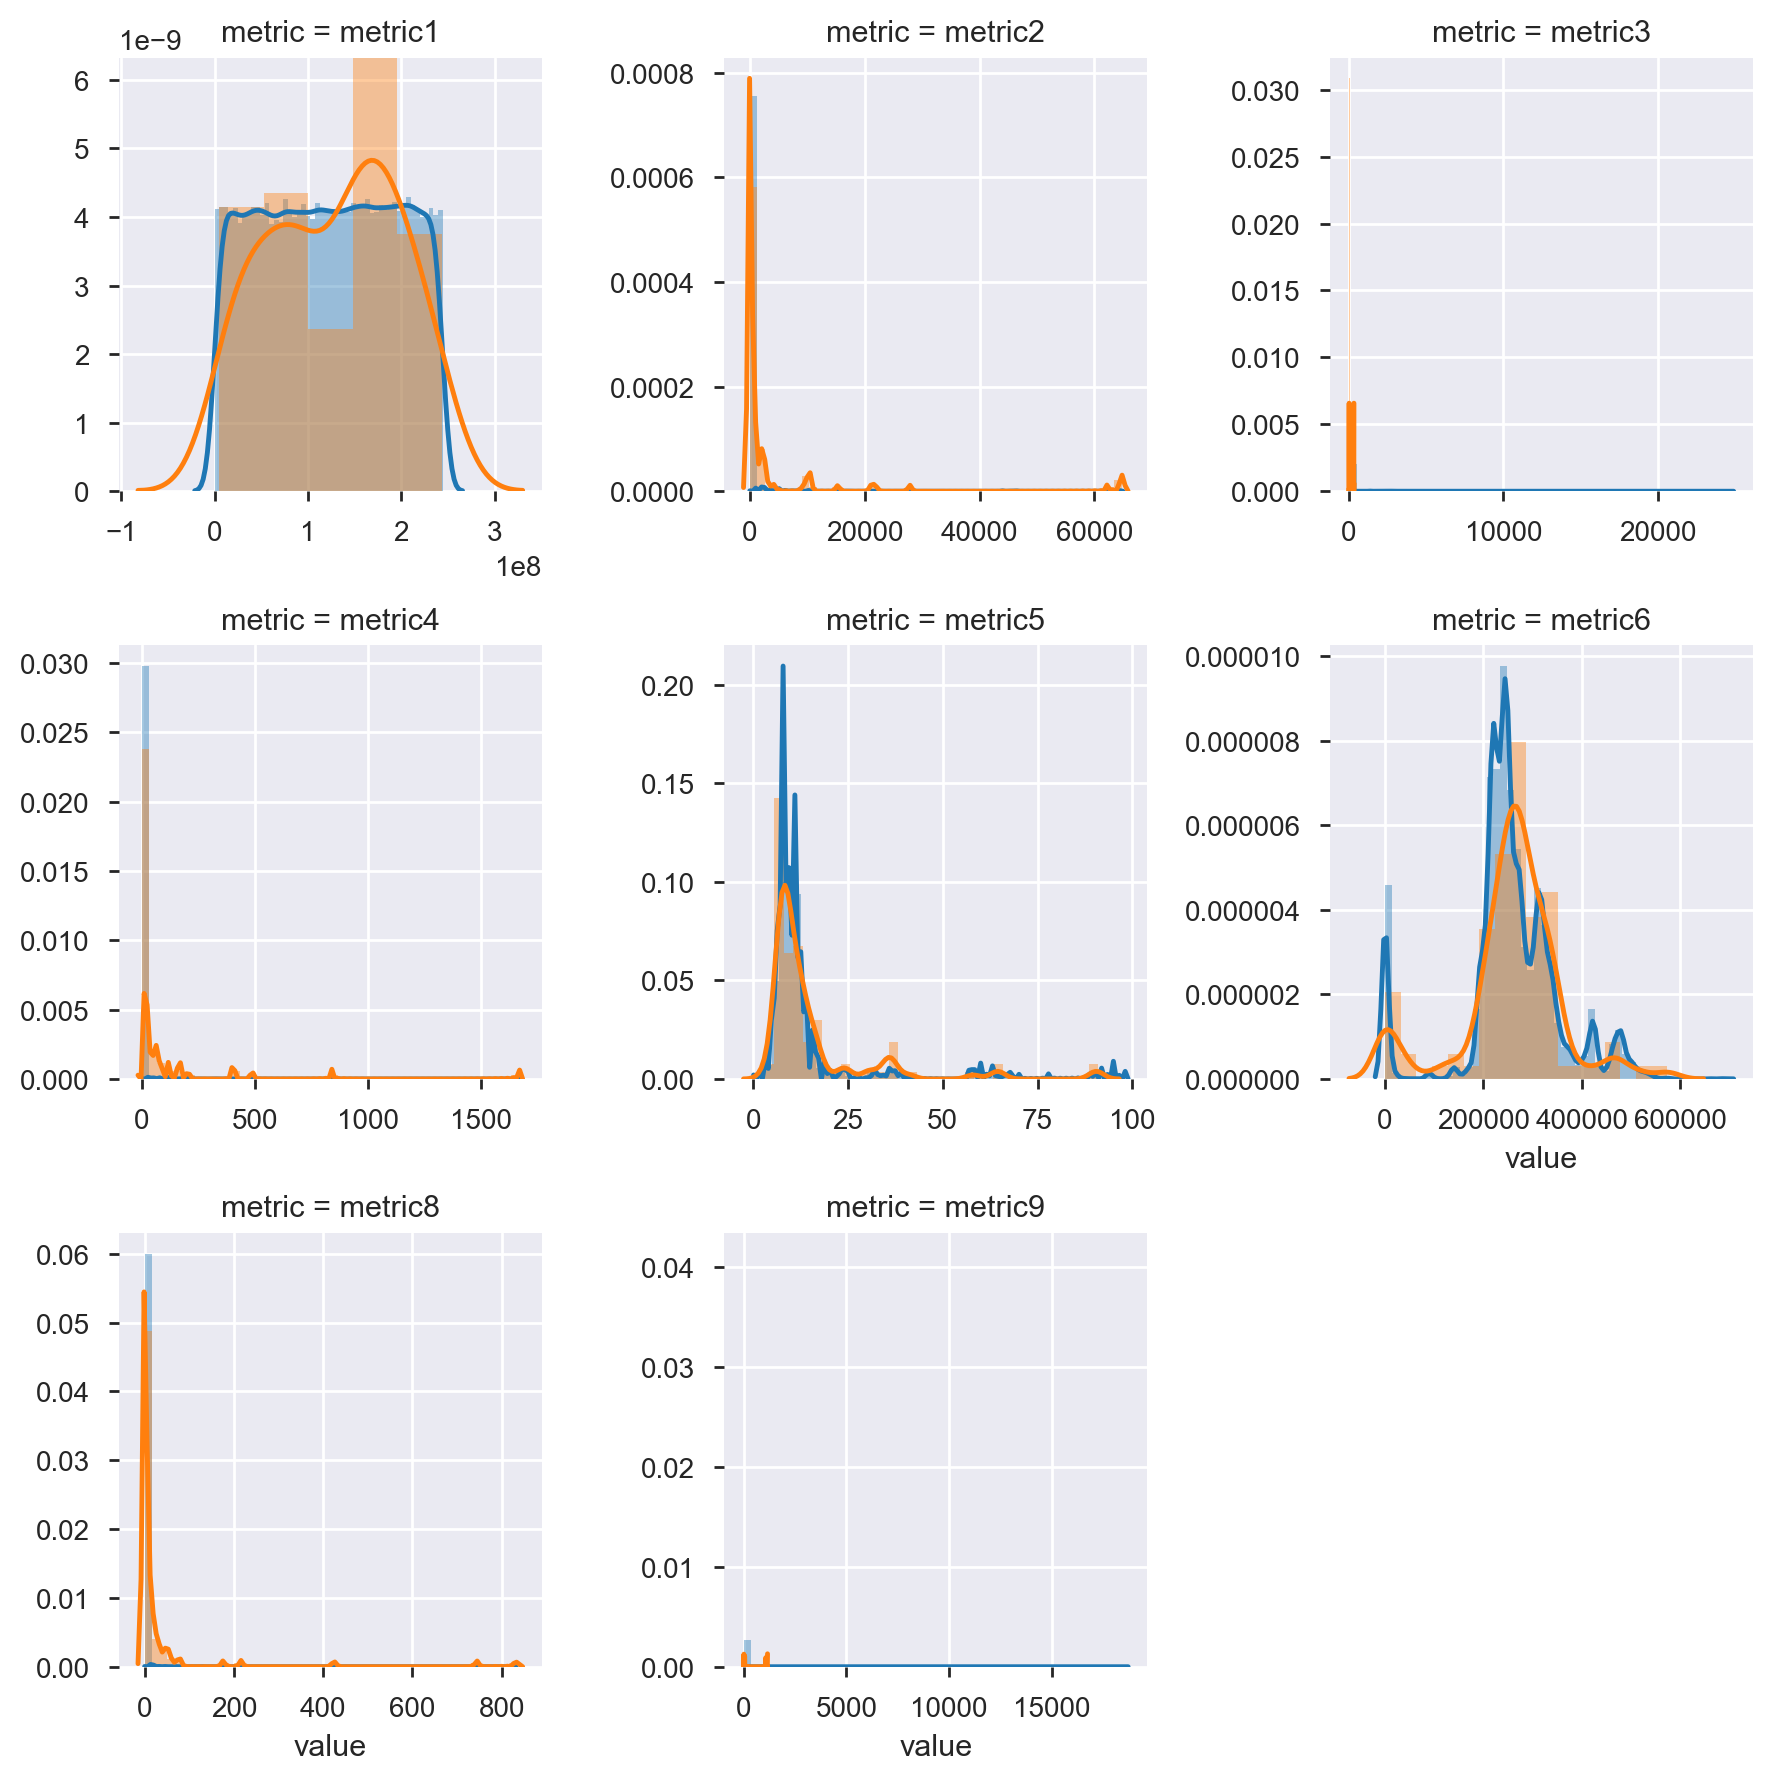

In [36]:
_ = data_df.melt(id_vars=['failure'], value_vars=metrics_num, var_name='metric')
g = sns.FacetGrid(data=_, col = "metric", hue='failure', sharey=False, sharex=False, col_wrap=3)
g.map(sns.distplot, 'value')
plt.show()

## Box plot

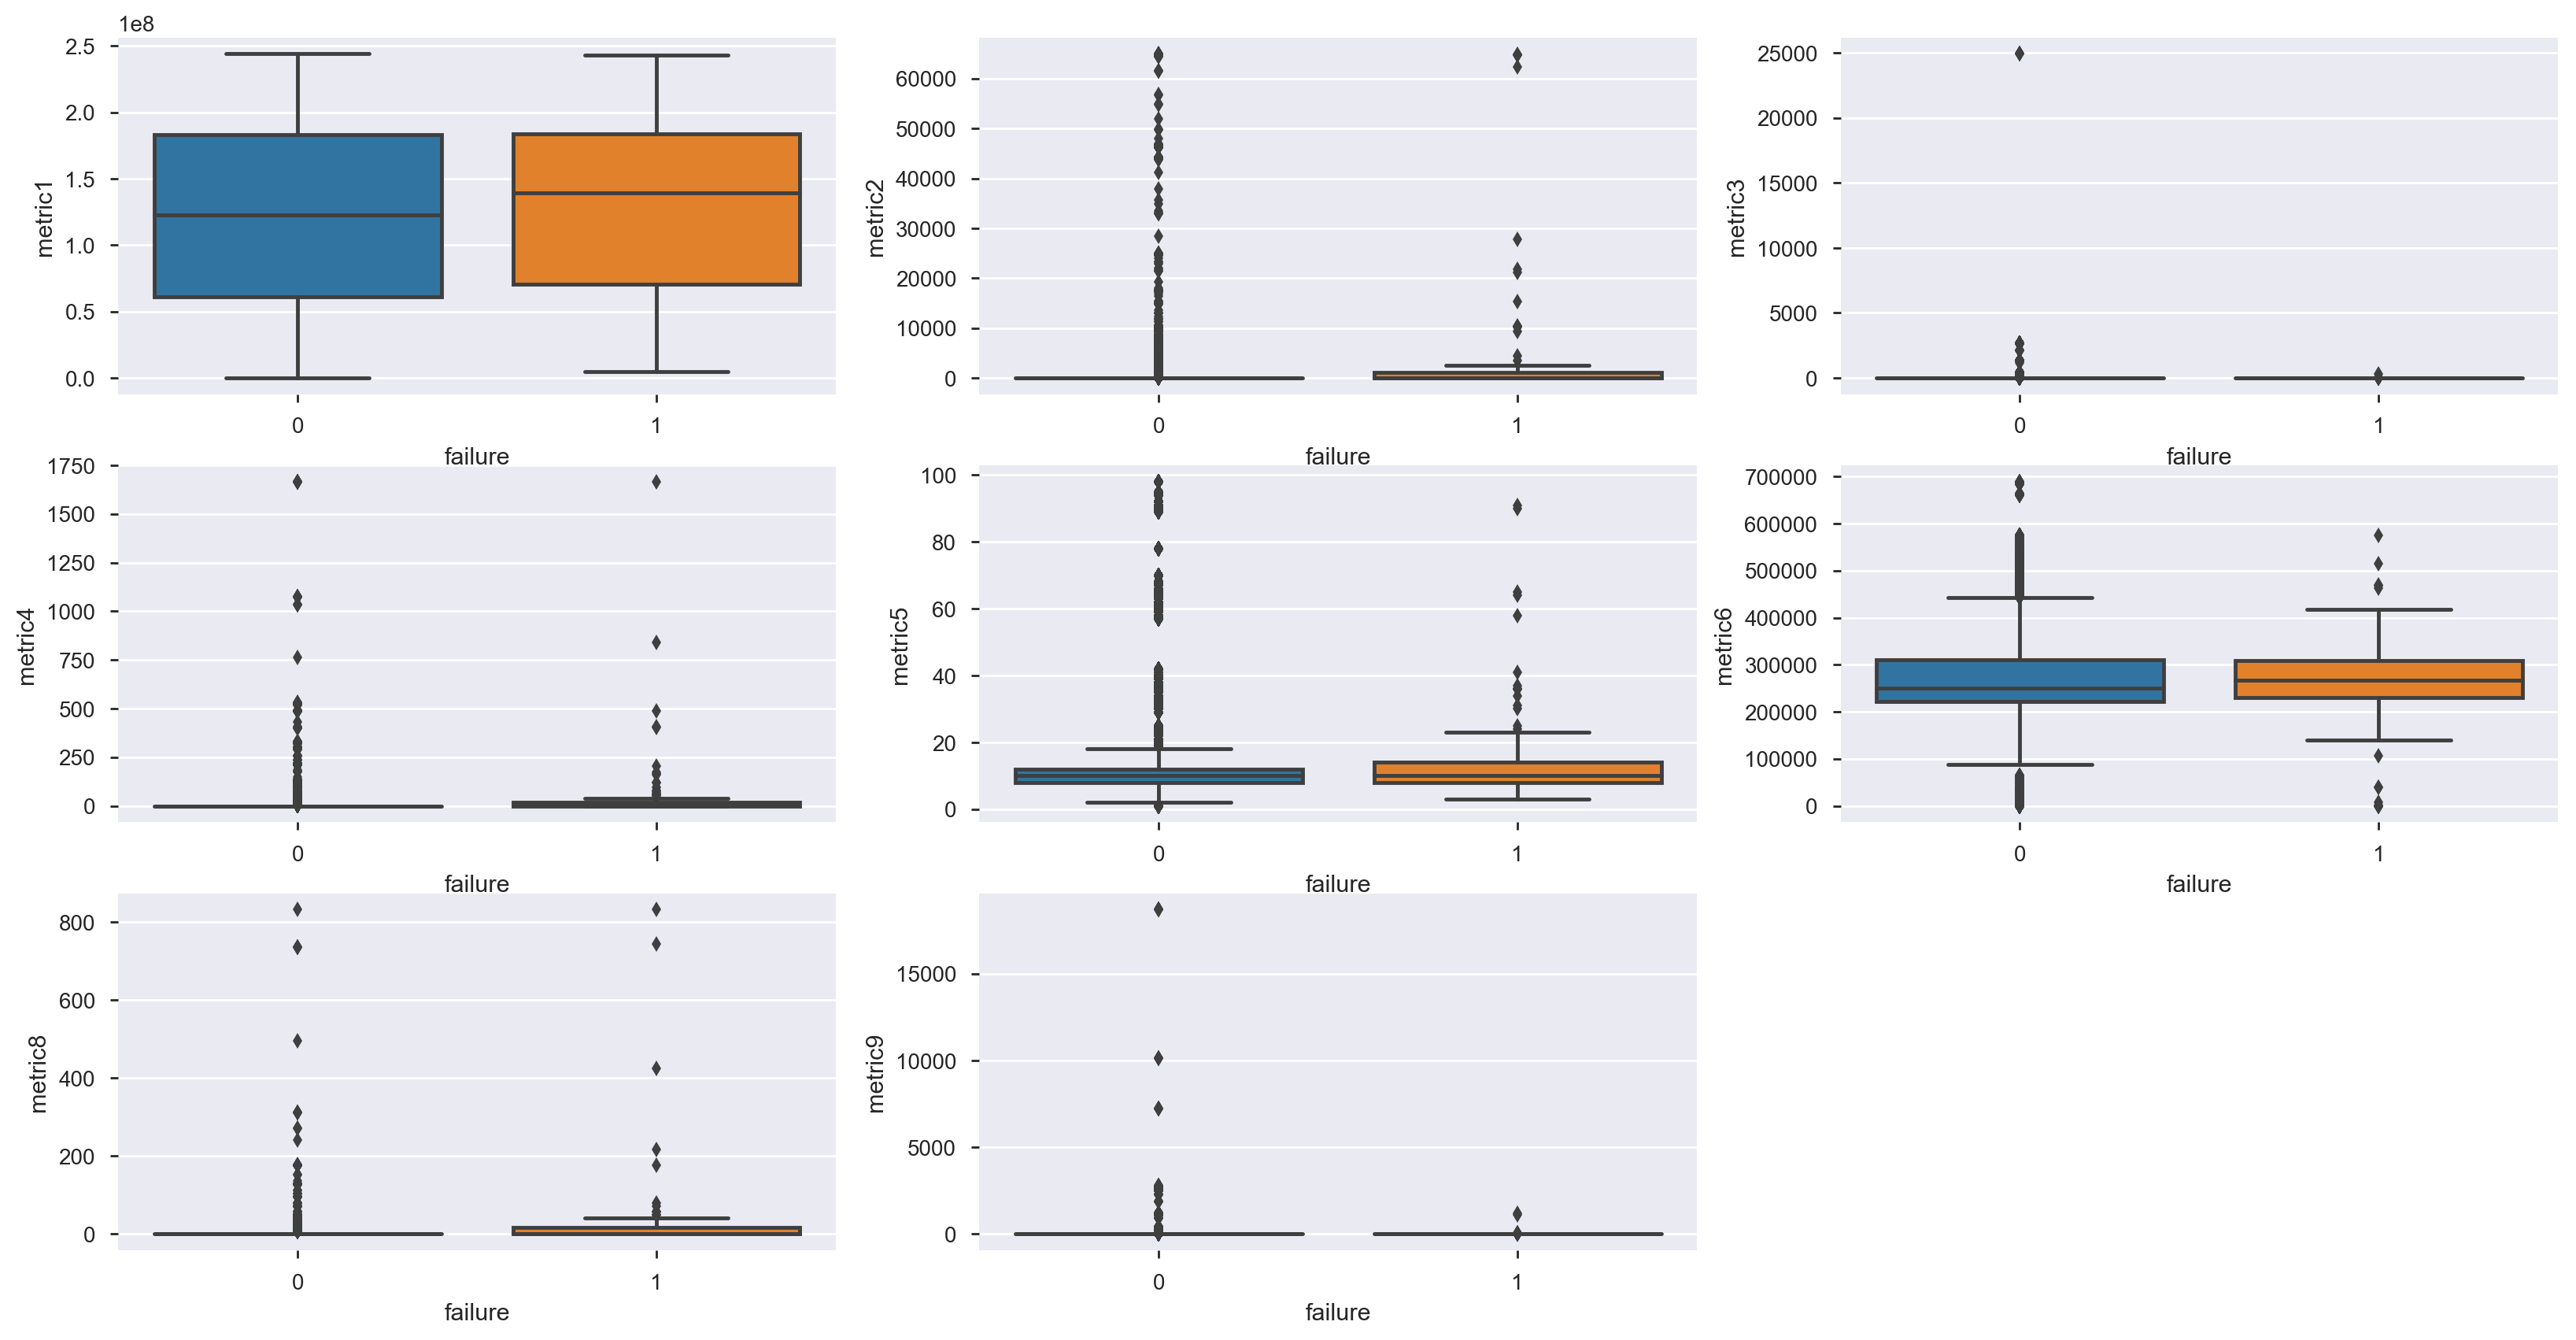

In [37]:
plt.figure(figsize=(20,10))
for i, c in enumerate(metrics_num):
    plt.subplot(3,3, i+1)
    sns.boxplot(x='failure', y=c, data=data_df)
plt.show()

## Date-Time relationship


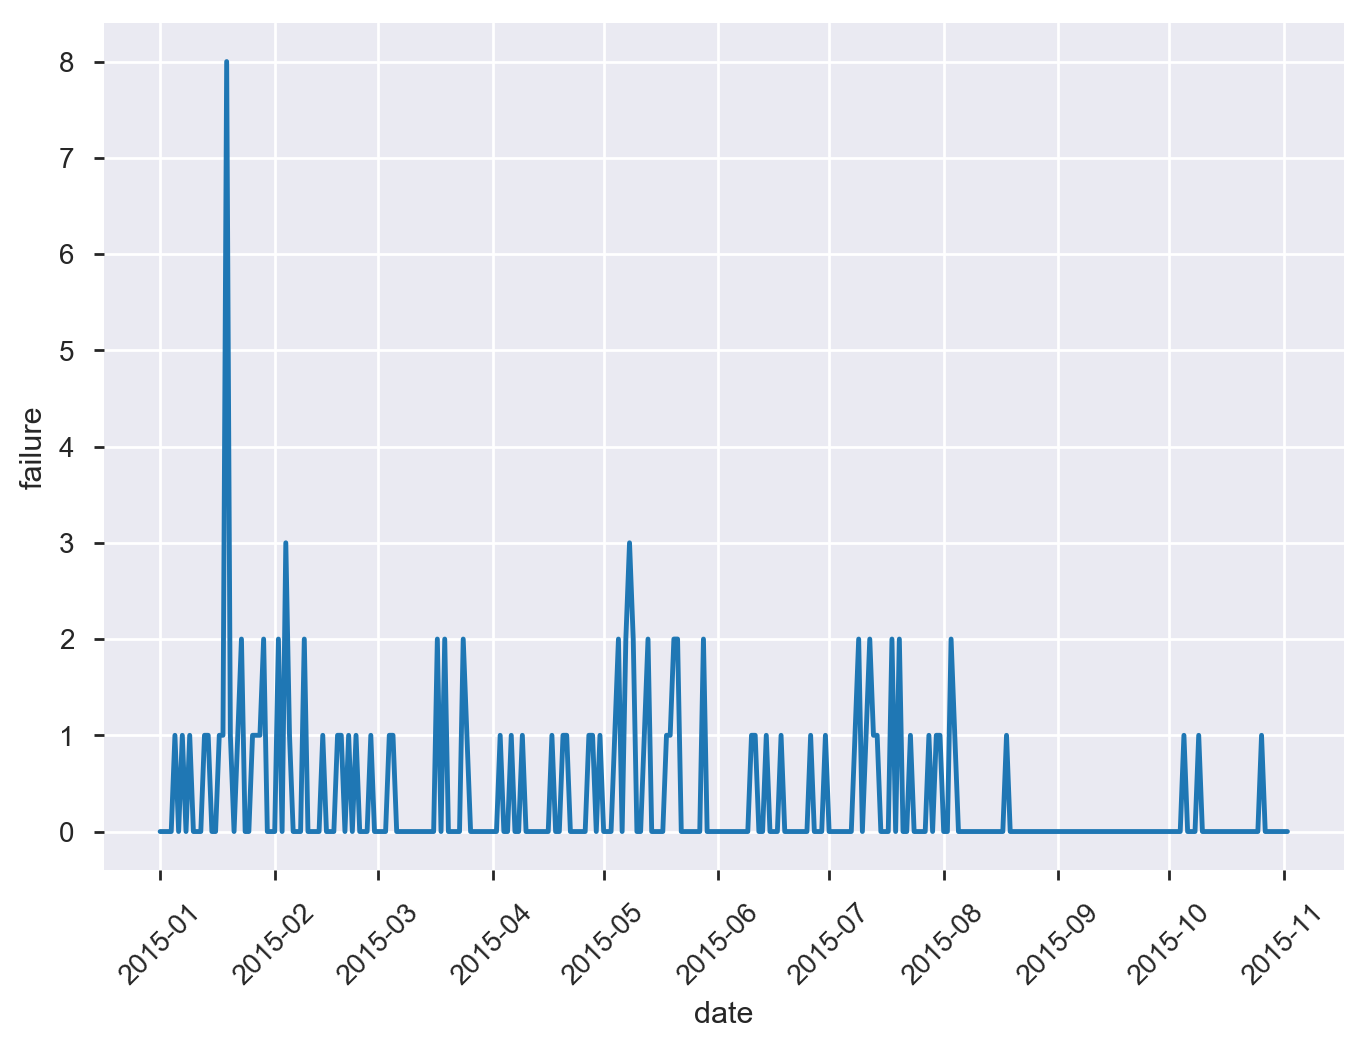

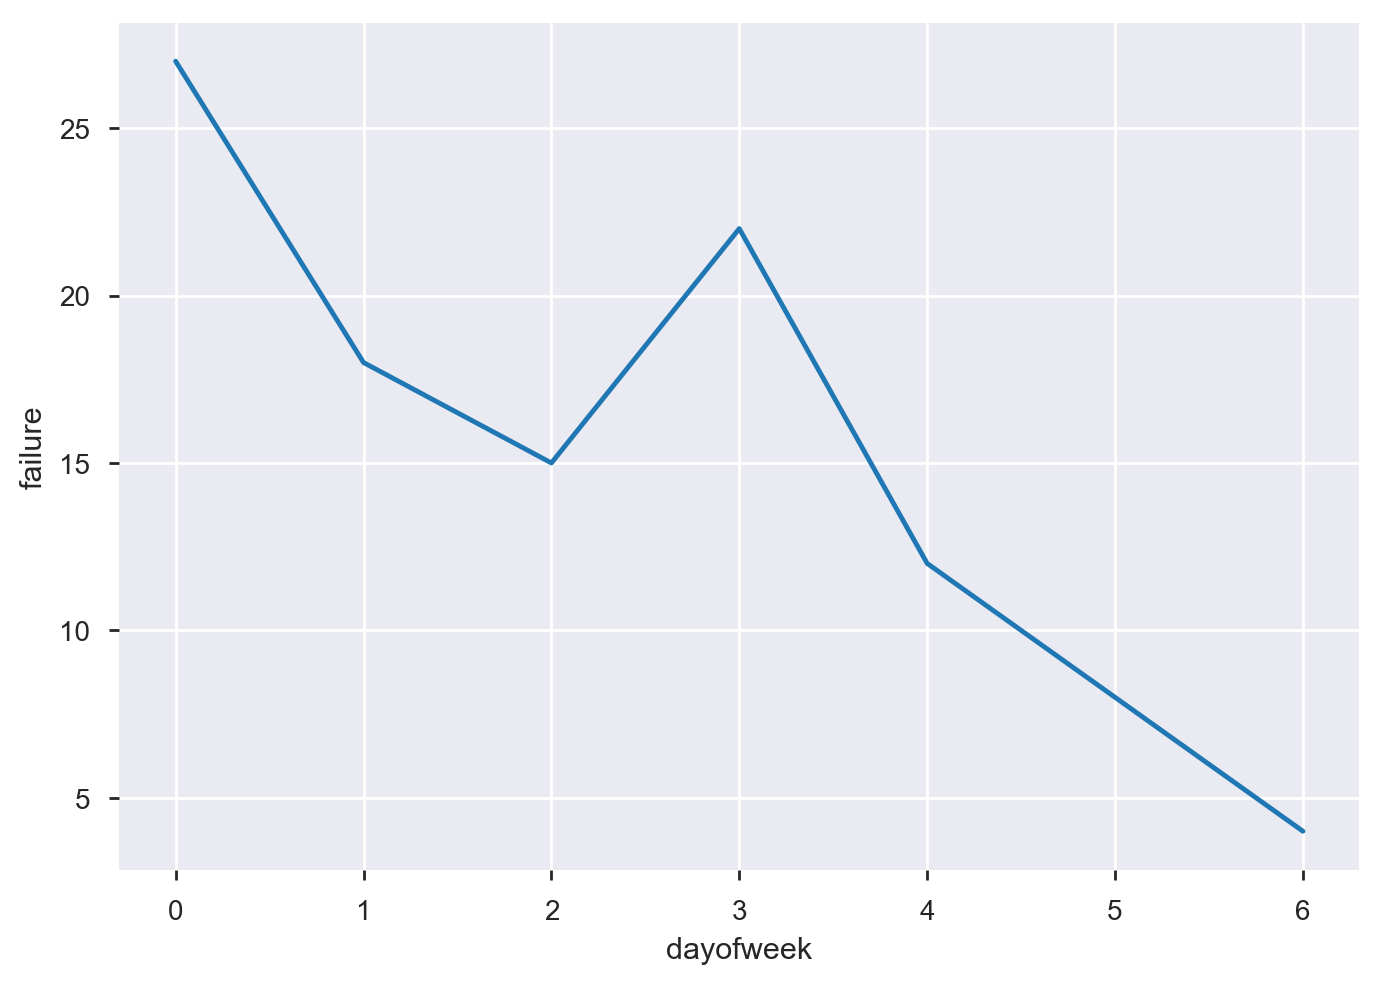

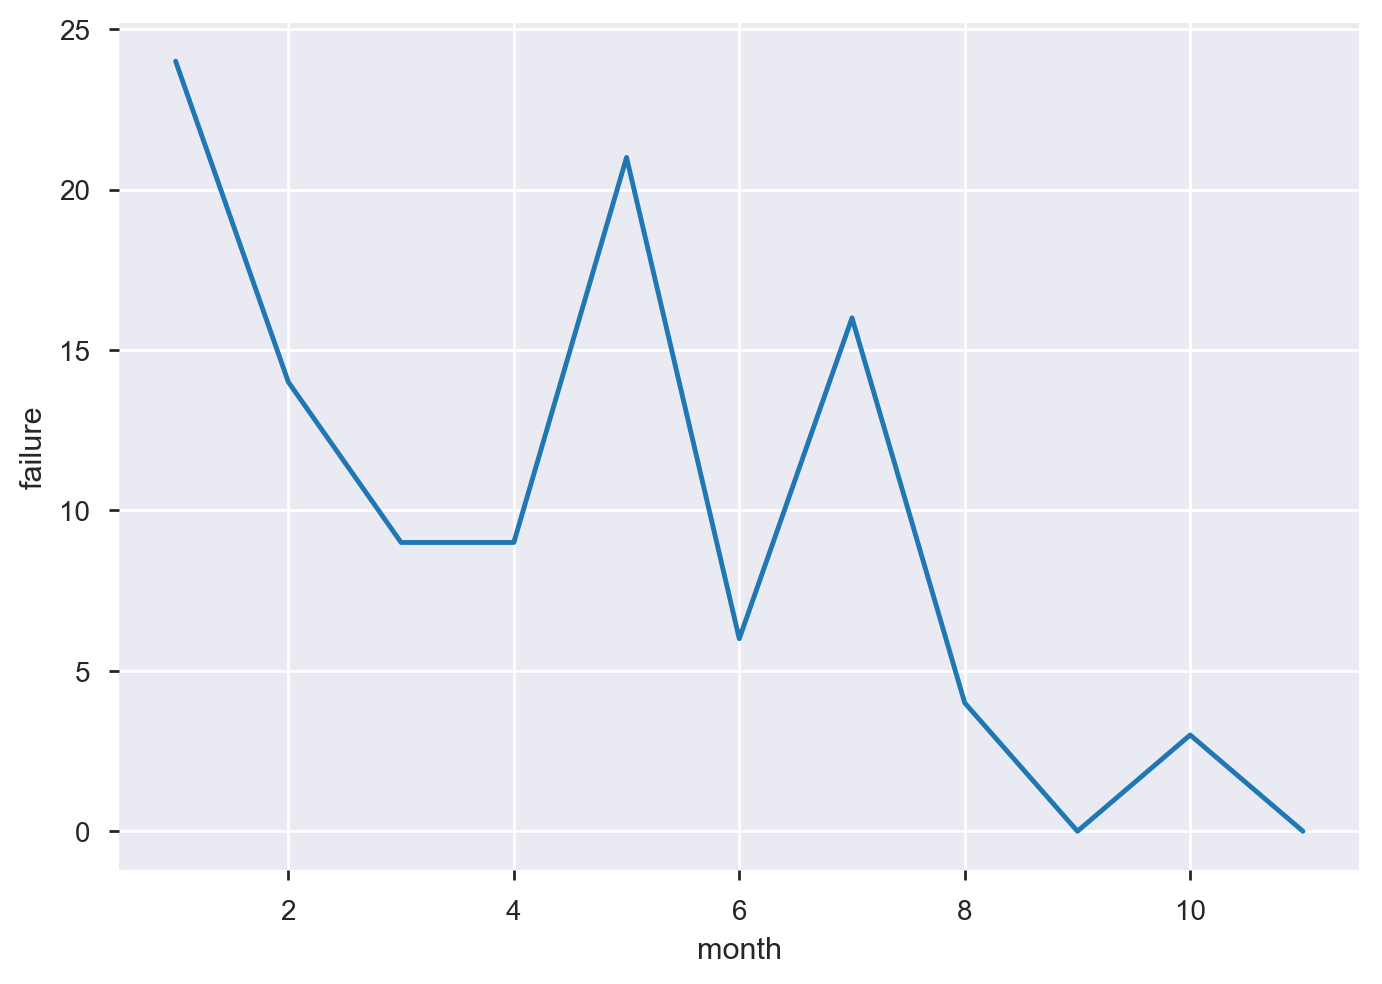

In [38]:
_ = data_df.groupby('date')['failure'].sum().reset_index()
ax = sns.lineplot(x='date', y='failure', data=_)
plt.xticks(rotation=45)
plt.show()

_ = data_df.groupby('dayofweek')['failure'].sum().reset_index()
sns.lineplot(x='dayofweek', y='failure', data=_)
plt.show()

_ = data_df.groupby('month')['failure'].sum().reset_index()
_ = _.sort_values(by=['month'])
sns.lineplot(x='month', y='failure', data=_)
plt.show()

We can see most of the faults are in the begining of the period and at the begining of the week, then the number start to decline towards the end.  

In [39]:
_1 = data_df[data_df.failure == 1]
_0 = data_df[data_df.failure == 0]
print('No of unique devices: {}'.format(len(data_df.id.unique())))
print('No of devices reported faults: {}'.format(len(_1.id.unique())))

No of unique devices: 1169
No of devices reported faults: 106


In [40]:
#Dropping date axis
data_df.drop('date', axis=1, inplace=True)

## Data splitting

In [65]:
from sklearn.model_selection import train_test_split

X = data_df.drop('failure', axis = 1)
y = data_df['failure'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print('No of 1s in training {}'.format(len(X_train[y_train==1])))
print('No of 1s in testing {}'.format(len(X_test[y_test==1])))

No of 1s in training 79
No of 1s in testing 27


## Converting categorial features

To experiment the impact of id, day, month of the week, One-hot encoding is used for the day of the week, month, and target encoding for the ids. The ids could refer to the type of the device.

In [66]:
import category_encoders as ce

hot_encoder = ce.OneHotEncoder(cols=['dayofweek', 'month'])
target_encoder = ce.TargetEncoder(cols=['id'])

X_train = hot_encoder.fit_transform(X_train)
X_train = target_encoder.fit_transform(X=X_train, y=y_train)

X_test  = hot_encoder.transform(X_test)
X_test = target_encoder.transform(X=X_test)

In [67]:
##categorial only features
metrics_cat = X_train.columns.difference(metrics_num)

In [68]:
X_train.head()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
17565,0.0,224268128,0,0,0,36,270531,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
85607,0.0,87440608,0,0,0,7,258719,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
75640,0.0,242071248,0,0,0,8,203915,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17638,0.0,7957072,0,0,0,13,244267,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
78432,0.0,188095056,0,0,0,14,351121,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [69]:
X_test.head()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
16030,0.000000,172385864,0,0,0,11,246986,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15740,0.000000,91862904,0,0,0,8,228613,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
94892,0.007042,118306704,0,0,0,16,336254,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
114947,0.000000,3810800,0,0,0,9,218911,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
59862,0.014706,235359016,936,0,2,8,190301,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Data standarisation for LinearRegression

In [70]:
##Scalling data. StandarScaler will scale the values to be within 1 standard deviation, 
#it might change distribution. MinMaxScaler does not change the distributin.
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[metrics_num] = scaler.fit_transform(X_train_scaled[metrics_num])
X_test_scaled[metrics_num] = scaler.transform(X_test_scaled[metrics_num])

## Oversampling minority class
Due to imbalanced classes, the minority class is oversampled using ADASYN/SMOTE techniques.

In [78]:
%%time
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SMOTENC

class Sampler(object):
    sampler = {'SMOTE':SMOTE(random_state=42), 
               'ADASYN':ADASYN(random_state=42),
               'SMOTENC':SMOTENC(random_state=42, 
                                 categorical_features=[X_train.columns.get_loc(c) for c in metrics_cat]),
               'RandomOverSampler':RandomOverSampler(random_state=42)}
    def __init__(self, name):
        self.smplr = self.sampler[name]
    
    def sampling(self, X_train, y_train):
        X_sampled, y_sampled = self.smplr.fit_resample(X_train, y_train)
        X_sampled = pd.DataFrame.from_records(X_sampled, columns=X_train.columns)
        y_sampled = pd.Series(y_sampled, name='failure')
        return X_sampled, y_sampled

#Sampling using different methods

#ADASYN uses a weighted distribution for different minority class examples according 
#to their level of difficulty in learning, where more synthetic data is generated
#for minority class examples that are harder to learn.
sampler = Sampler('ADASYN')
X_train_ADASYN, y_train_ADASYN = sampler.sampling(X_train[metrics_num], y_train)
X_train_scaled_ADASYN, y_train_scaled_ADASYN = sampler.sampling(X_train_scaled[metrics_num], y_train)
X_test_ADASYN, y_test_ADASYN = sampler.sampling(X_test[metrics_num], y_test)

#SMOTENC takes the categorial data into consideration when oversampling
sampler = Sampler('SMOTENC')
X_train_sampled_SMOTENC, y_train_sampled_SMOTENC = sampler.sampling(X_train, y_train)
X_test_sampled_SMOTENC, y_test_sampled_SMOTENC = sampler.sampling(X_test, y_test)

X_train_scaled_SMOTENC, y_train_scaled_SMOTENC = sampler.sampling(X_train_scaled, y_train)
X_test_scaled_SMOTENC, y_test_scaled_SMOTENC = sampler.sampling(X_test_scaled, y_test)


CPU times: user 7min 34s, sys: 2.22 s, total: 7min 36s
Wall time: 7min 35s


## Classifier class definition

The class works as a wraper for different algorithms

In [85]:
#### Classifiers class
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, mean_absolute_error,accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


class Classifier(object):
    
    
    classifier = {'LogisticRegression':LogisticRegression(),
                  'XGBoost':xgb.XGBClassifier(),
                  'SVM': svm.SVC(),
                  'RandomForestClassifier': RandomForestClassifier()}
    
    
    #Classifier initial parameters
    clfr_init_param = {'LogisticRegression':{'random_state':42, 
                                             
                                             'max_iter':5
                                             }, 
                       'XGBoost': {'objective':'binary:logistic', 
                                   'max_delta_step': 1, 
                                   'random_state':42, 
                                   'min_child_weight':1},
                       'SVM': {'kernel': 'rbf', 
                               'class_weight':'balanced', 
                               'random_state':42},
                       'RandomForestClassifier': {'random_state':42}
                      }
    
    #Classifier tunning parameters
    clfr_tune_param = {'LogisticRegression':{'C':[0.005, 0.01, 0.1, 1.], 
                                             'penalty':['l1', 'l2'],
                                             'class_weight':[{1:10,0:1},{1:1,0:1}, 'balanced']
                                            },

                       'SVM': {'C':[0.005, 0.01, 0.1], 
                               'gamma':[0.001, 0.01, 0.1, 1]},
                       
                       'RandomForestClassifier': {'bootstrap': [True, False],
                                                  'max_depth': [10, 20, 30],
                                                  'max_features': ['auto', 'sqrt'],
                                                  'min_samples_leaf': [1, 2, 4],
                                                  'min_samples_split': [2, 5, 10],
                                                  'n_estimators': [200, 600, 800, 1000, 1200]},
                        'XGBoost':{
                                    'learning_rate': (0.001, 0.01, 'log-uniform'),
                                    'max_depth': (2, 6),
                                    'subsample': (0.1, 1.0, 'uniform'),
                                    'colsample_bytree': (0.1, 1.0, 'uniform'),
                                    'n_estimators': (400, 2000),
                                    'gamma': (0, 10., 'uniform')
                                    }
                      }
                           
    def __init__(self, name):
        self.name = name
        self.tune_param = {'clsfr__'+k: v for k,v in self.clfr_tune_param[name].items()}
        self.model = self.classifier[name].set_params(**self.clfr_init_param[name])   

## Plot class definition

In [80]:
#Plot class
class Plot:
    
    def __init__(self):
        pass
    
    @staticmethod  
    def plot_auc(y_test, y_pred_prob):
       
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr, marker='.')
        plt.show()
        auc_score = roc_auc_score(y_test, y_pred_prob)
        print('AUC: %.3f' % auc_score)
    
    @staticmethod
    def plot_precision_recall(y_test, y_pred_prob):
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob) 
        plt.title("Precision-Recall vs Threshold Chart")
        plt.plot(thresholds, precision[:-1], "b--", label="Precision")
        plt.plot(thresholds, recall[:-1], "r--", label="Recall")
        plt.ylabel("Precision, Recall")
        plt.xlabel("Threshold")
        plt.legend(loc="lower left")
        plt.ylim([0,1])
        plt.show()

        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve')
        plt.show()
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        
        print("Classification Report: \n", classification_report(y_true=y_true, y_pred=y_pred))
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
        print("\nAccuracy",accuracy)
        
        conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
        print('Confusion matrix:\n', conf_mat)

        labels = ['Class 0', 'Class 1']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()

## Hyberparameter class definition (Grid+Baysian search)

In [81]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Cross validation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

class HyperTuning(object):
    
    def __init__(self):
        pass
    
    @staticmethod
    def grid_search(name, X_train, y_train):
        clfr = Classifier(name)
        pipe = Pipeline([('clsfr', clfr.model)])

        grid = GridSearchCV(pipe, cv=cv, 
                            param_grid=clfr.tune_param, 
                            iid=True, 
                            scoring='precision_weighted', 
                            verbose=3, 
                            n_jobs=-1,
                            refit=True
                           )

        grid.fit(X_train, y_train)
        
        print('Finished GridSearch')
        
        return grid 
    
    @staticmethod
    def baysian_search(name, X_train, y_train):
        clfr = Classifier(name)
        pipe = Pipeline([('clsfr', clfr.model)])

        opt = BayesSearchCV(
              estimator=pipe,
              scoring='f1_weighted',
              search_spaces = [(clfr.tune_param, 5)], # (parameter space, # of evaluations)
              cv=cv,
              verbose = True,
              n_jobs = -1,
              refit = True,
              random_state = 42
            )
        opt.fit(X_train, y_train)
        print('Finished Training')
        
        return opt
        
    
    @staticmethod
    def evaluate_opt(opt, X, y):
        print('Best model\n')
        print(opt.best_estimator_)
        print('\n')
        print('Best score on the validation: {}'.format(opt.best_score_))
        result_df = pd.DataFrame(opt.cv_results_)\
          .loc[:,['mean_test_score', 'rank_test_score', 'params']].sort_values(by='rank_test_score')
        print(result_df)
        print("*******************Training************************")
        print("Best. score: %s" % opt.best_score_)

        y_pred_prob = opt.predict_proba(X['train'])[:,1]
        y_pred = opt.predict(X['train'])
        Plot.confusion_matrix(y['train'], y_pred)

        ##################################
        print("*****************Testing***************************")

        y_pred_prob = opt.predict_proba(X['test'])[:,1]
        y_pred = opt.predict(X['test'])
        Plot.plot_auc(y_test, y_pred_prob)
        Plot.confusion_matrix(y['test'], y_pred)
        Plot.plot_precision_recall(y['test'], y_pred_prob)

## LinearRegression with SMOTENC Oversampling (All features)

It is clear that the model is overfitted on the training data. That is could be due to the 'id', day and month feature

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.7s finished


Finished GridSearch
Best model

Pipeline(memory=None,
     steps=[('clsfr', LogisticRegression(C=0.1, class_weight={1: 1, 0: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=5,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


Best score on the validation: 0.9845947262146032
    mean_test_score  rank_test_score  \
16         0.984595                1   
14         0.984595                1   
20         0.984222                3   
22         0.984222                3   
23         0.978668                5   
21         0.978668                5   
17         0.977934                7   
15         0.977934                7   
8          0.977688                9   
10         0.977688                9   
11         0.974562               11   
9          0.974562               11   
4          0.974561               13   
2          0.974561               13   
5 

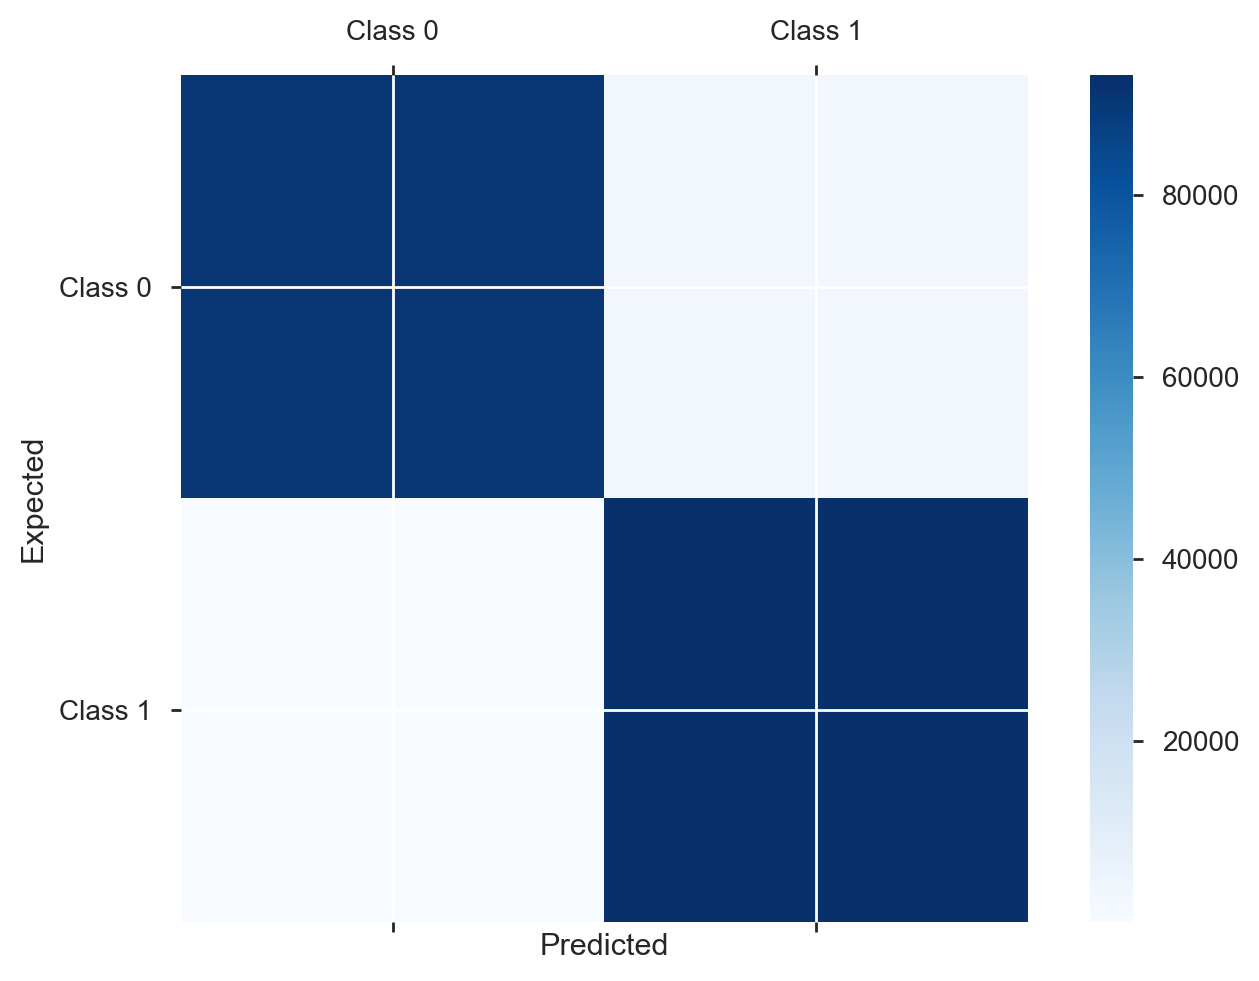

*****************Testing***************************


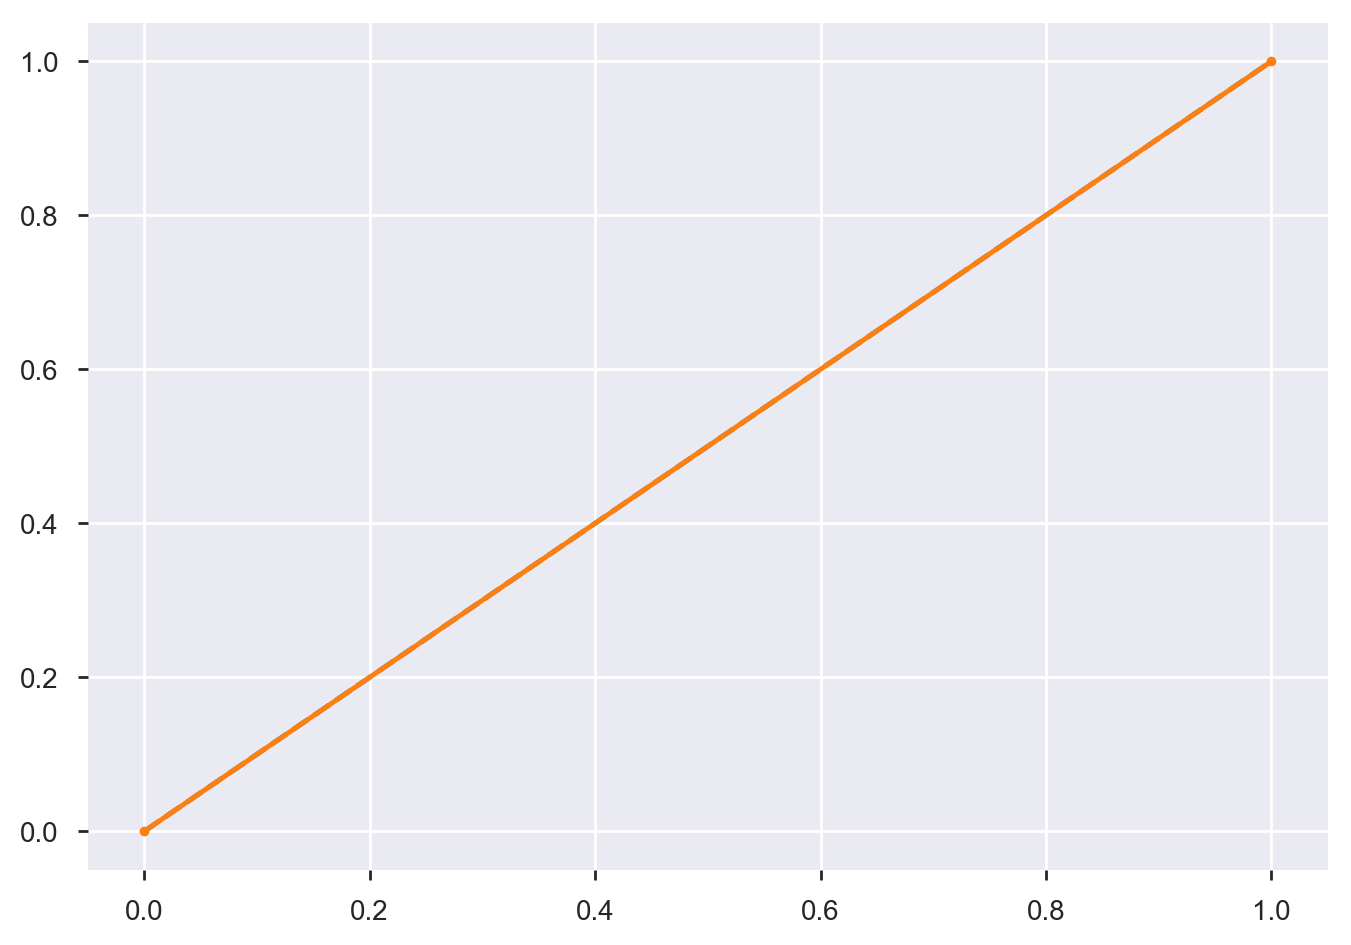

AUC: 0.500
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     31097
           1       0.00      1.00      0.00        27

   micro avg       0.00      0.00      0.00     31124
   macro avg       0.00      0.50      0.00     31124
weighted avg       0.00      0.00      0.00     31124


Accuracy 0.0008674977509317568
Confusion matrix:
 [[    0 31097]
 [    0    27]]


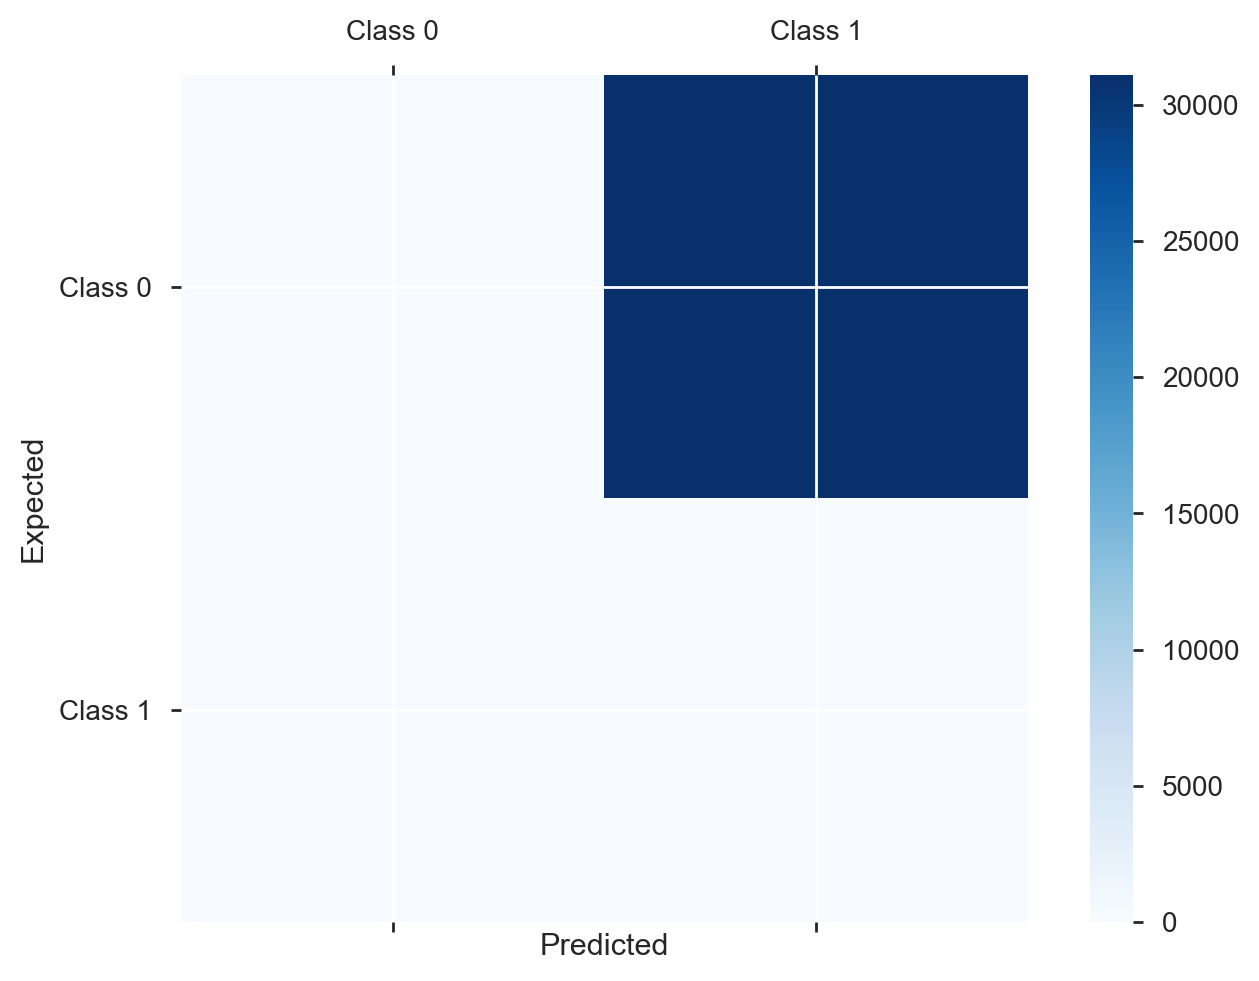

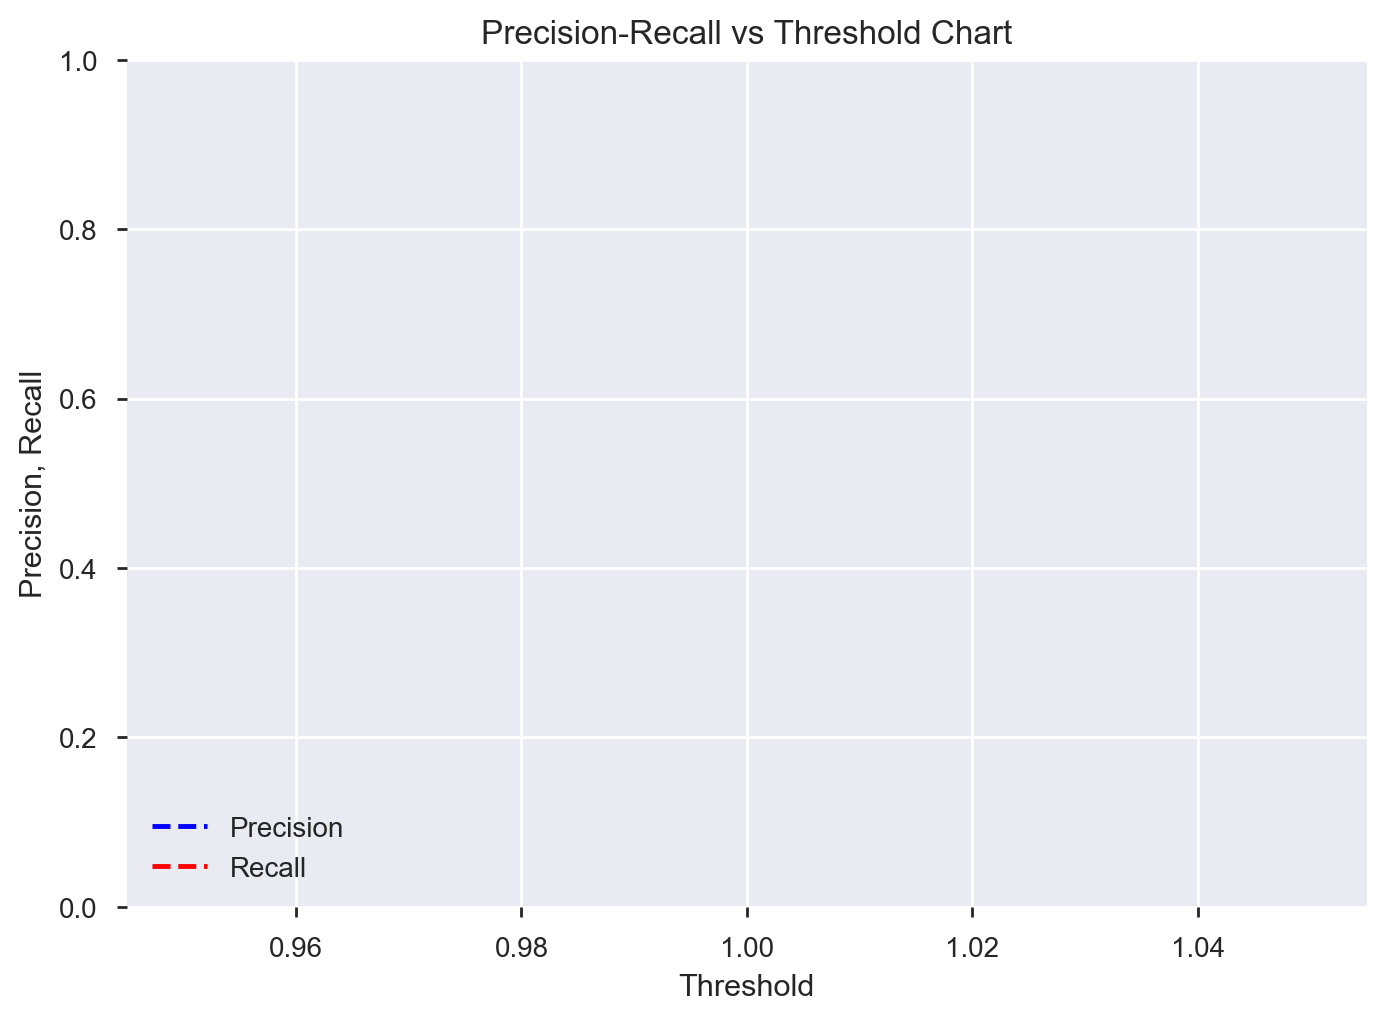

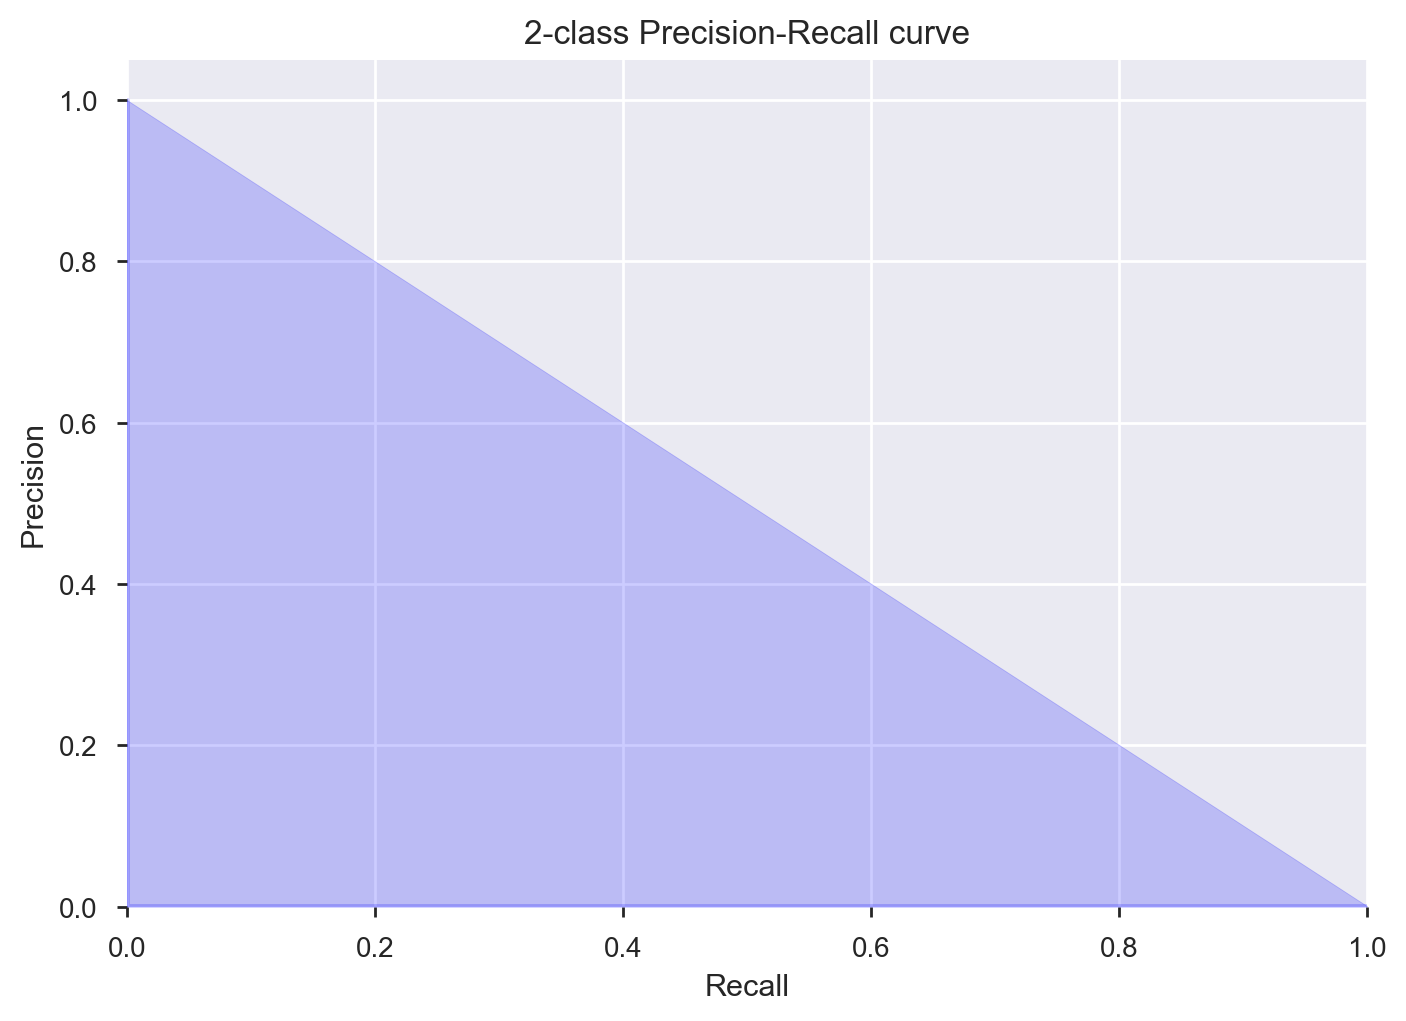

In [82]:
%time 
name = 'LogisticRegression'
X = {'train': X_train_scaled_SMOTENC, 'test':X_test}
y = {'train': y_train_scaled_SMOTENC, 'test':y_test}

grid = HyperTuning.grid_search(name, X_train_scaled_SMOTENC, 
                                     y_train_scaled_SMOTENC)
HyperTuning.evaluate_opt(grid, X, y)

## XGBoost with ADASYN Oversampling

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


Finished Training
Best model

Pipeline(memory=None,
     steps=[('clsfr', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8195980974464558, gamma=4.380291864409234,
       learning_rate=0.003362174400516434, max_delta_step=1, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1846, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7453280360438532))])


Best score on the validation: 0.9645366227013534
   mean_test_score  rank_test_score  \
0         0.959670                1   
1         0.961240                1   
2         0.930036                1   
3         0.959986                1   
4         0.964537                1   

                                              params  
0  {'clsfr__colsample_bytree': 0.4690935629679824...  
1  {'clsfr__colsample_bytree': 0.8536495199979559...  
2  {'cls

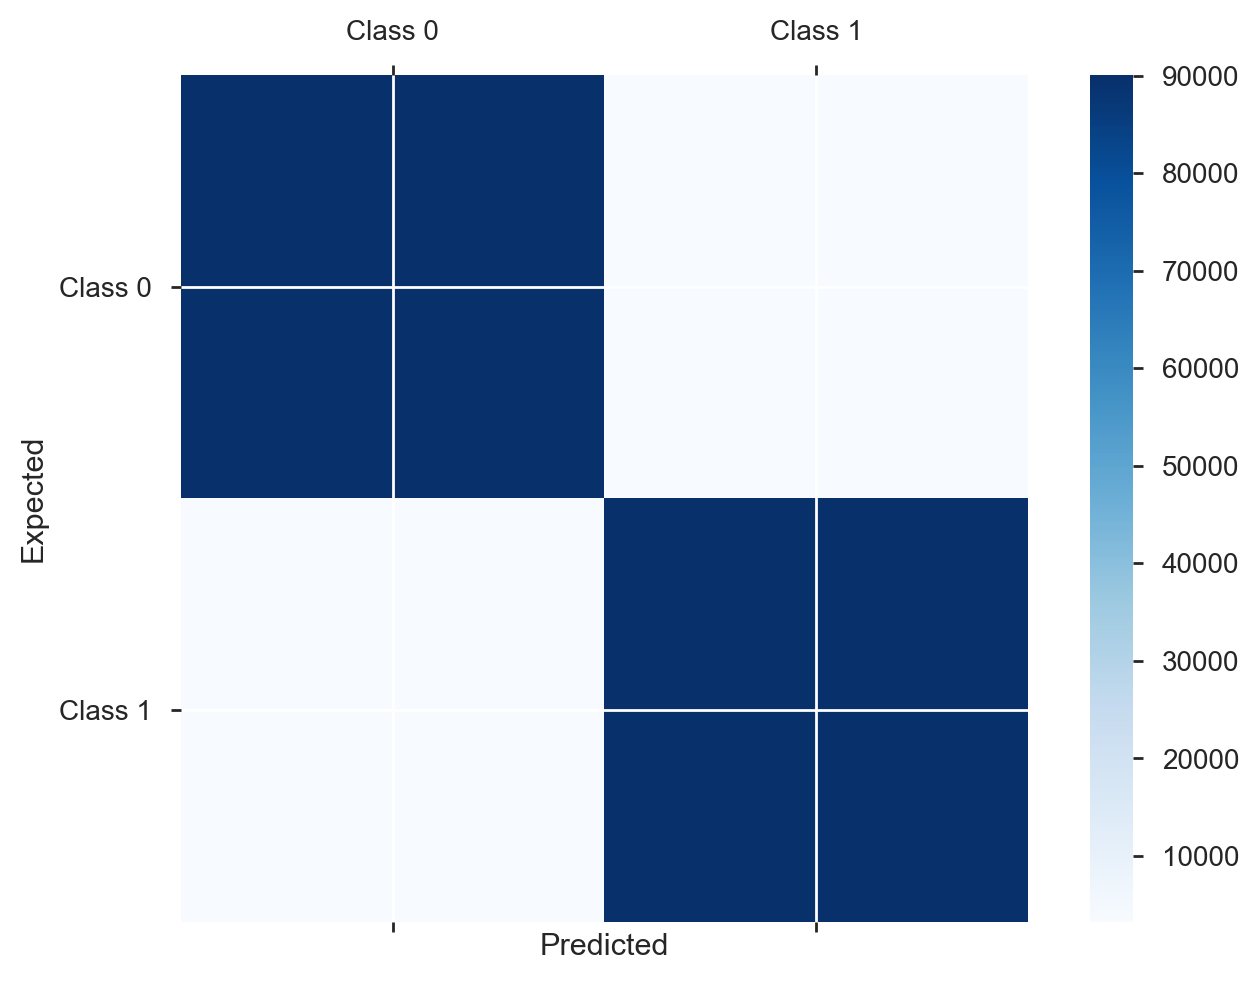

*****************Testing***************************


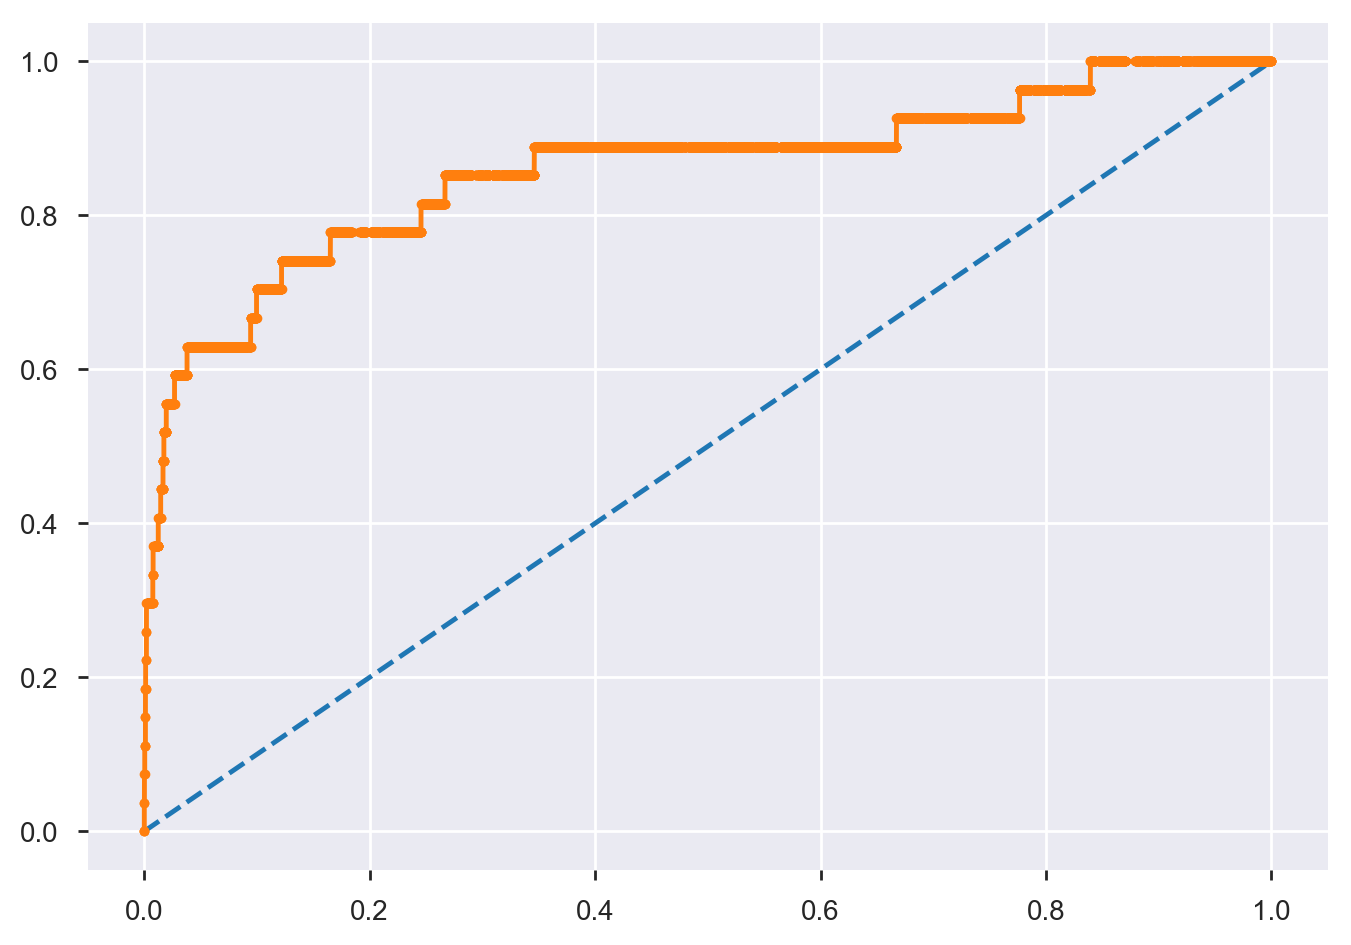

AUC: 0.860
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     31097
           1       0.01      0.59      0.03        27

   micro avg       0.97      0.97      0.97     31124
   macro avg       0.51      0.78      0.51     31124
weighted avg       1.00      0.97      0.98     31124


Accuracy 0.9655571263333762
Confusion matrix:
 [[30036  1061]
 [   11    16]]


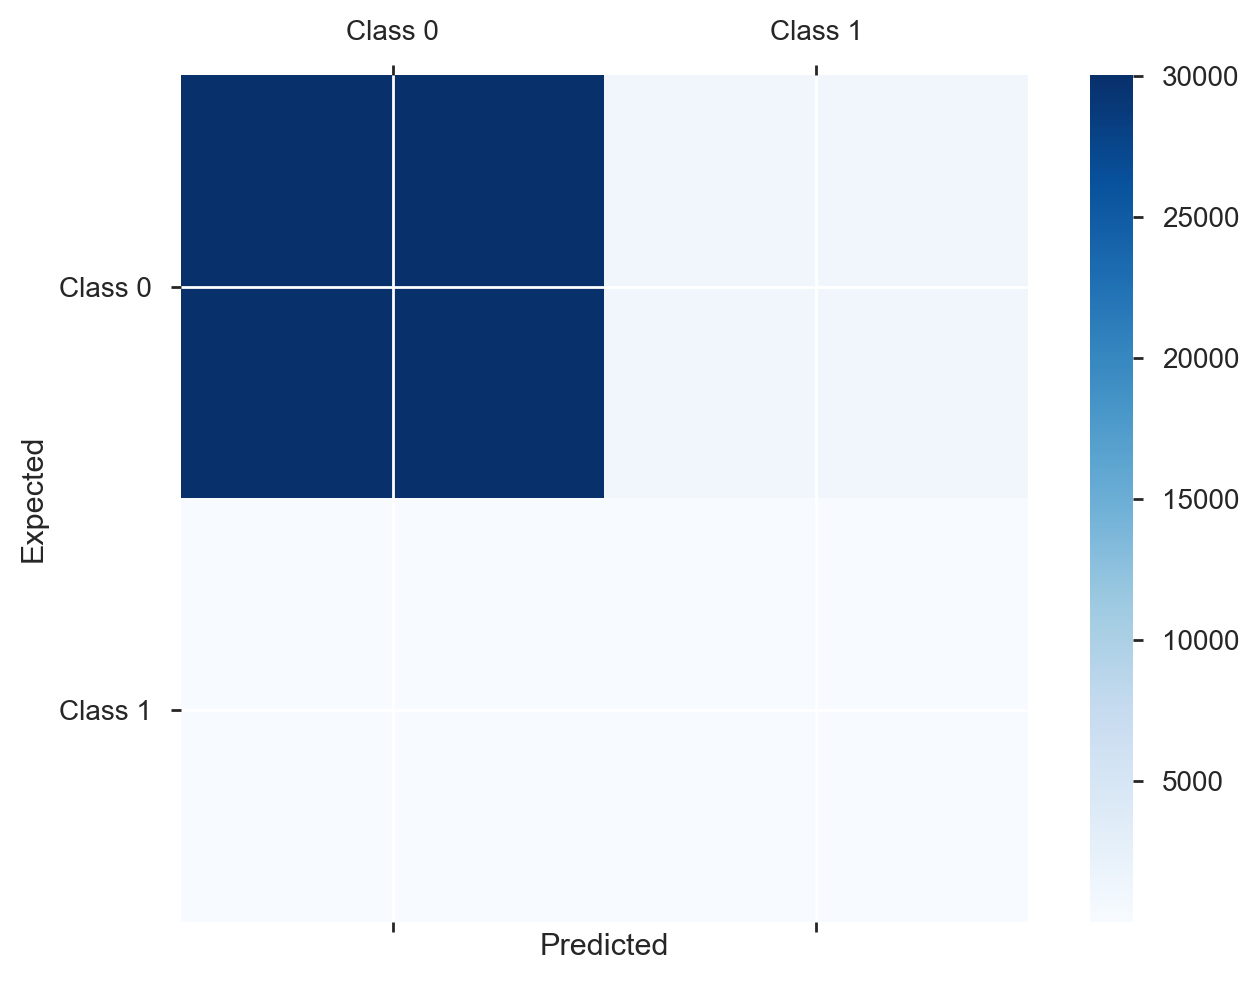

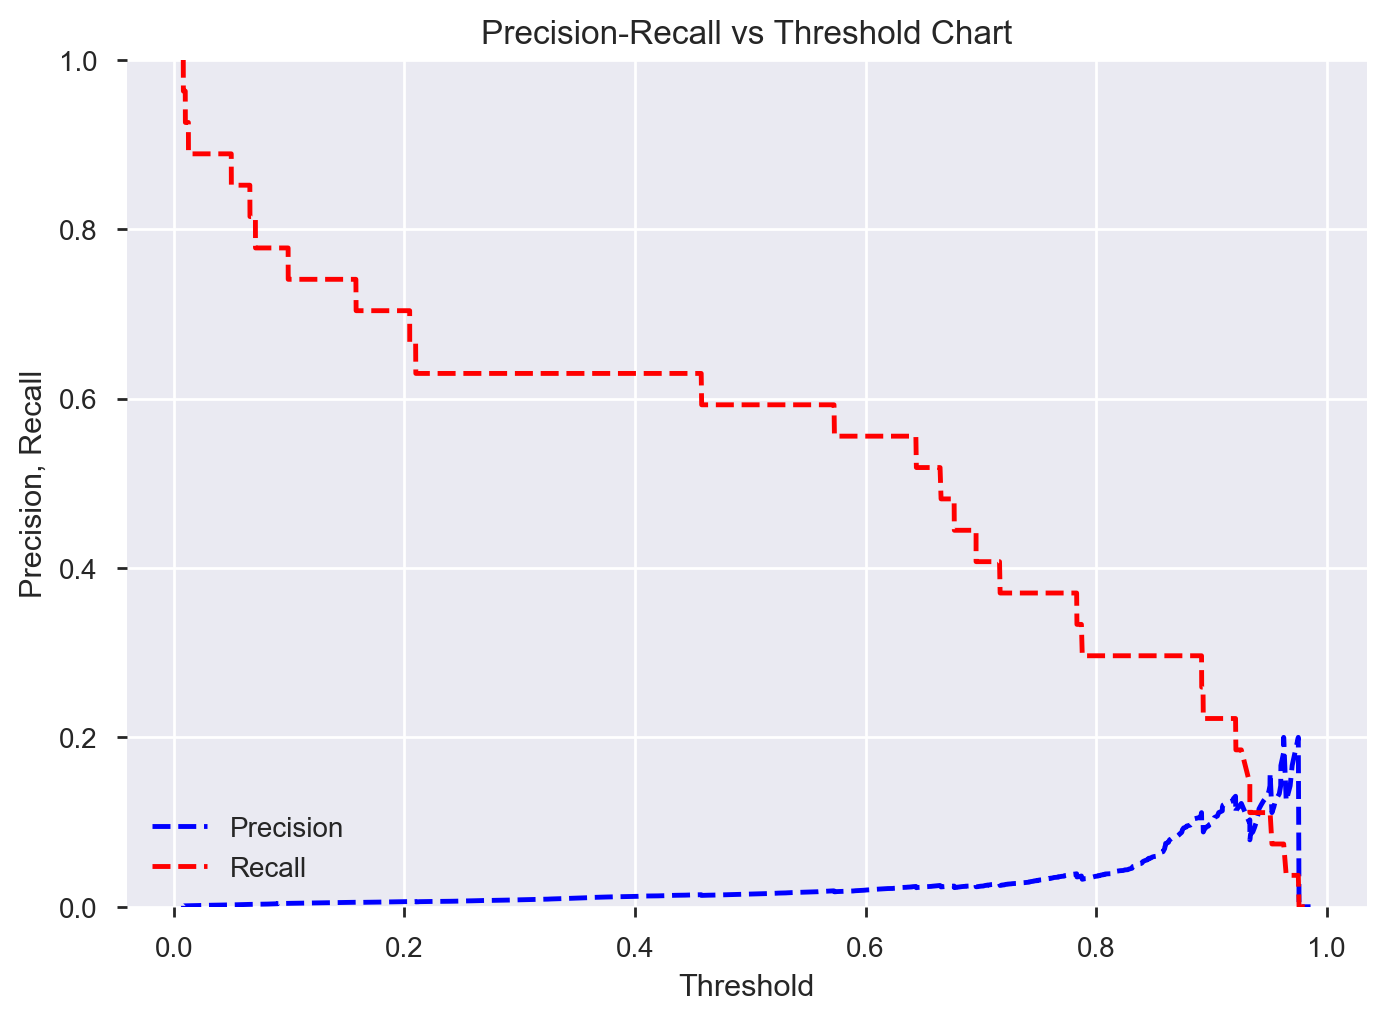

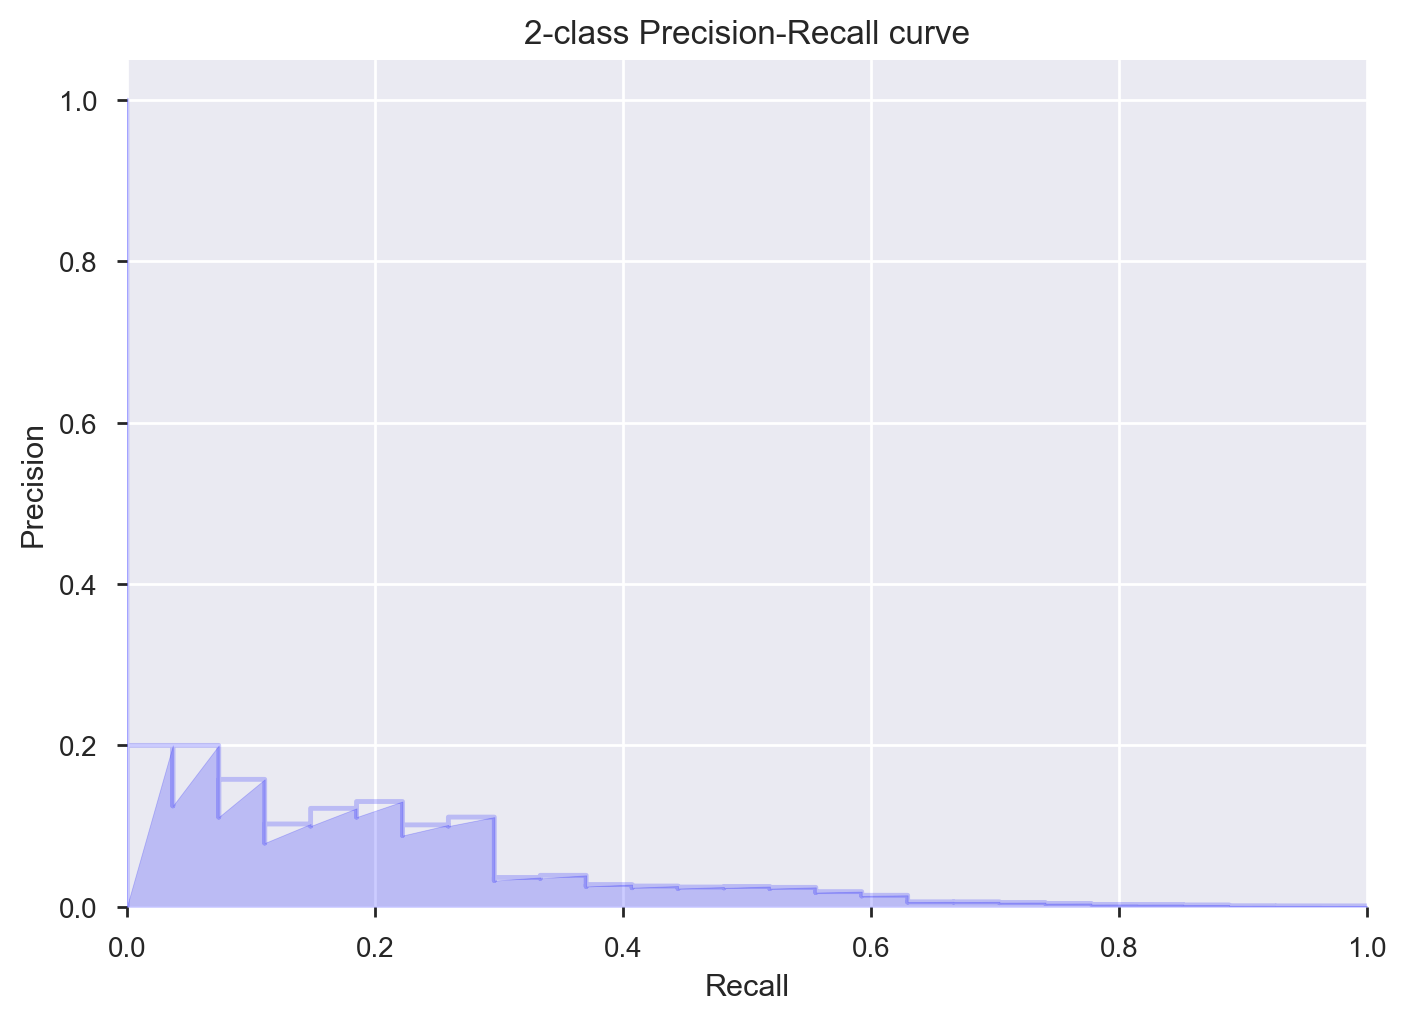

In [86]:
%time 
name = 'XGBoost'
features = X_train_ADASYN.columns
X = {'train': X_train_ADASYN.as_matrix(), 'test':X_test[features].as_matrix()}
y = {'train': y_train_ADASYN.as_matrix(), 'test':y_test.as_matrix()}

opt = HyperTuning.baysian_search(name, X['train'], y['train'])
HyperTuning.evaluate_opt(opt, X, y)

### Calibiration of probabilities

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     31097
           1       0.02      0.56      0.04        27

   micro avg       0.98      0.98      0.98     31124
   macro avg       0.51      0.77      0.52     31124
weighted avg       1.00      0.98      0.99     31124


Accuracy 0.9777020948464208
Confusion matrix:
 [[30415   682]
 [   12    15]]


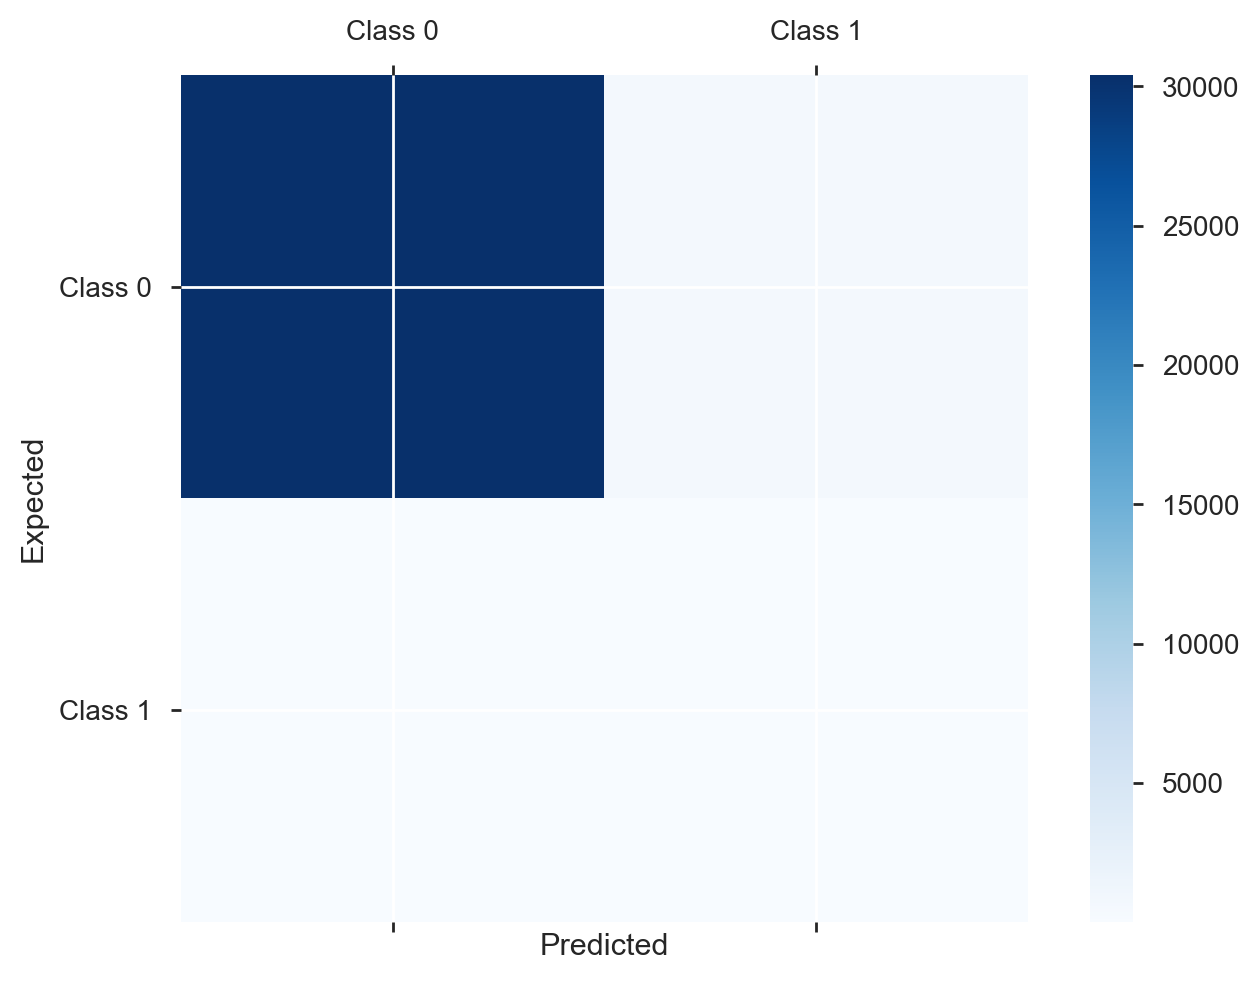

In [88]:
# calibrate model on validation data
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(opt, method='isotonic', cv='prefit')
calibrator.fit(X['train'], y['train'])
# evaluate the model
y_pred = calibrator.predict(X_test[features].as_matrix())
Plot.confusion_matrix(y['test'], y_pred)

### Predicting on oversampled test data

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.98      0.90     31097
           1       0.97      0.81      0.89     31104

   micro avg       0.90      0.90      0.90     62201
   macro avg       0.91      0.90      0.90     62201
weighted avg       0.91      0.90      0.90     62201


Accuracy 0.896143148823974
Confusion matrix:
 [[30415   682]
 [ 5778 25326]]


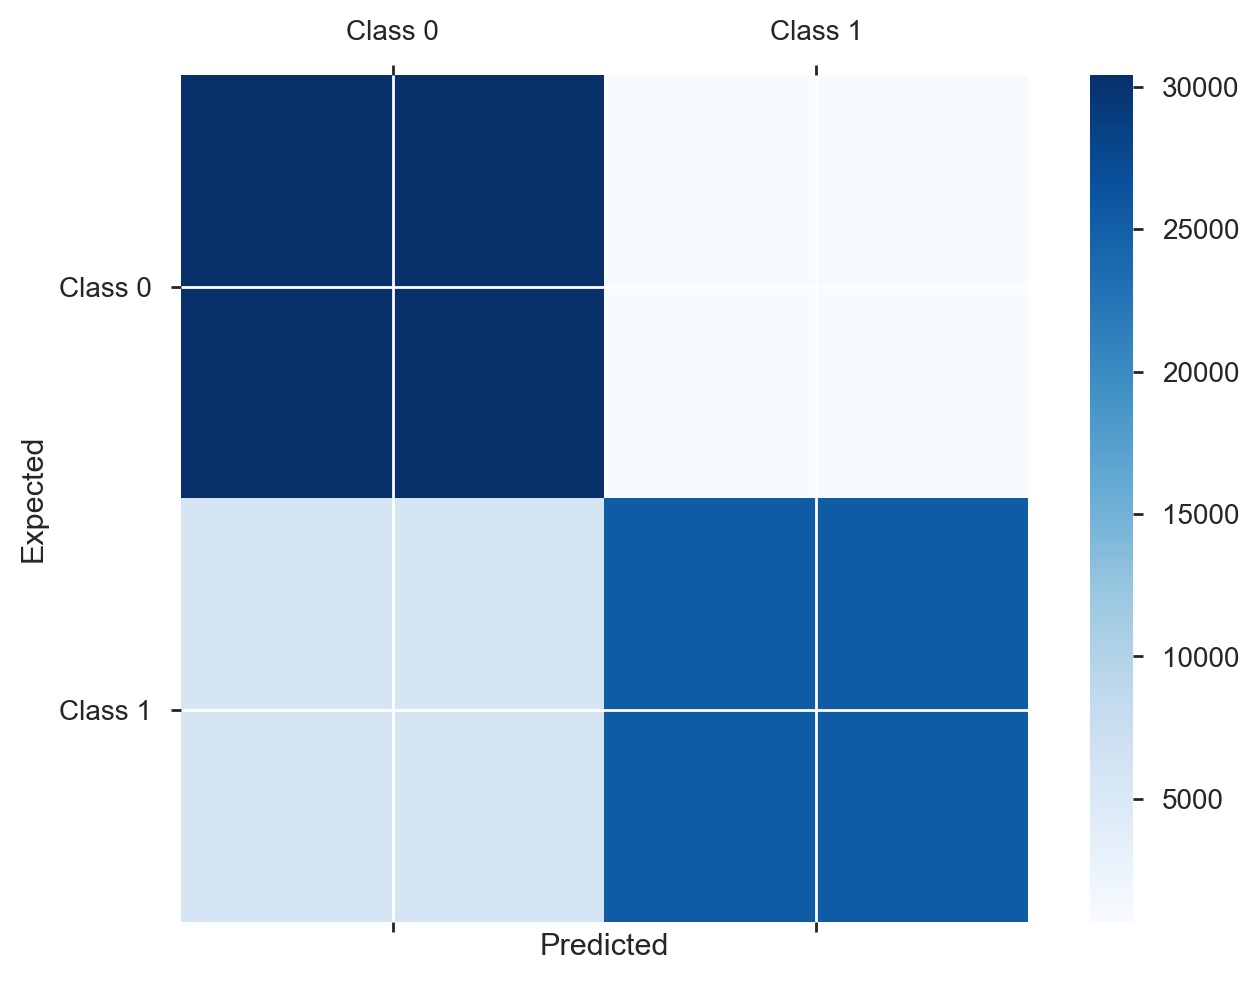

In [89]:
y_pred_test = calibrator.predict(X_test_ADASYN[features].as_matrix())
Plot.confusion_matrix(y_test_ADASYN, y_pred_test)

## XGBoost with SMOTENC Oversampling (All features)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.3 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Finished Training
Best model

Pipeline(memory=None,
     steps=[('clsfr', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.46909356296798244, gamma=7.277257431773251,
       learning_rate=0.008567773934012713, max_delta_step=1, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1472, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4727067692369846))])


Best score on the validation: 0.9985421944029759
*******************Training************************
Best. score: 0.9985421944029759
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93291
           1       1.00      1.00      1.00     93291

   micro avg       1.00      1.00      1.00    186582
   macro avg       1.00      1.00      1.00    186582
weighted avg       1.00   

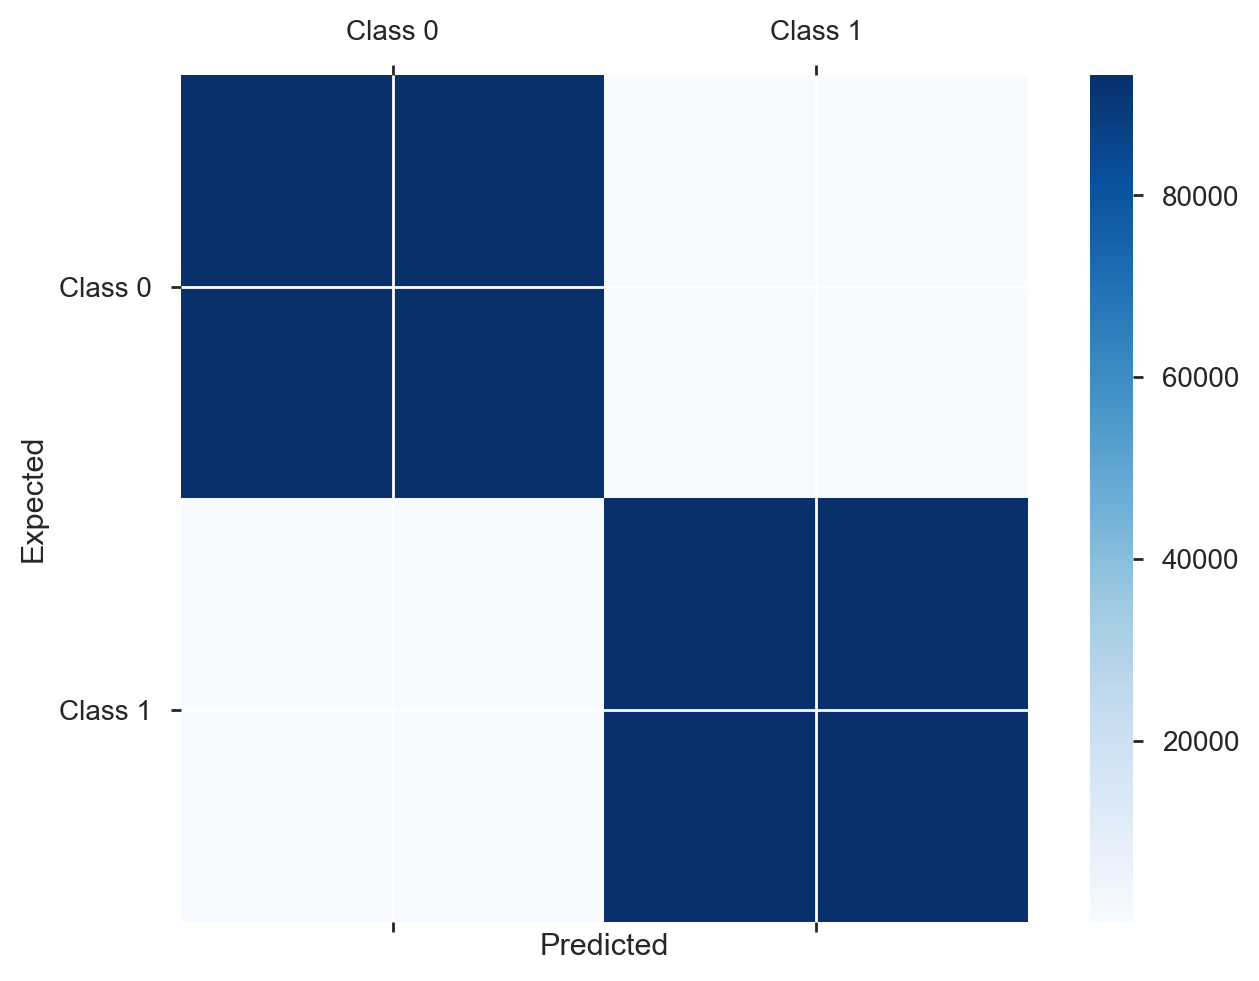

*****************Testing***************************


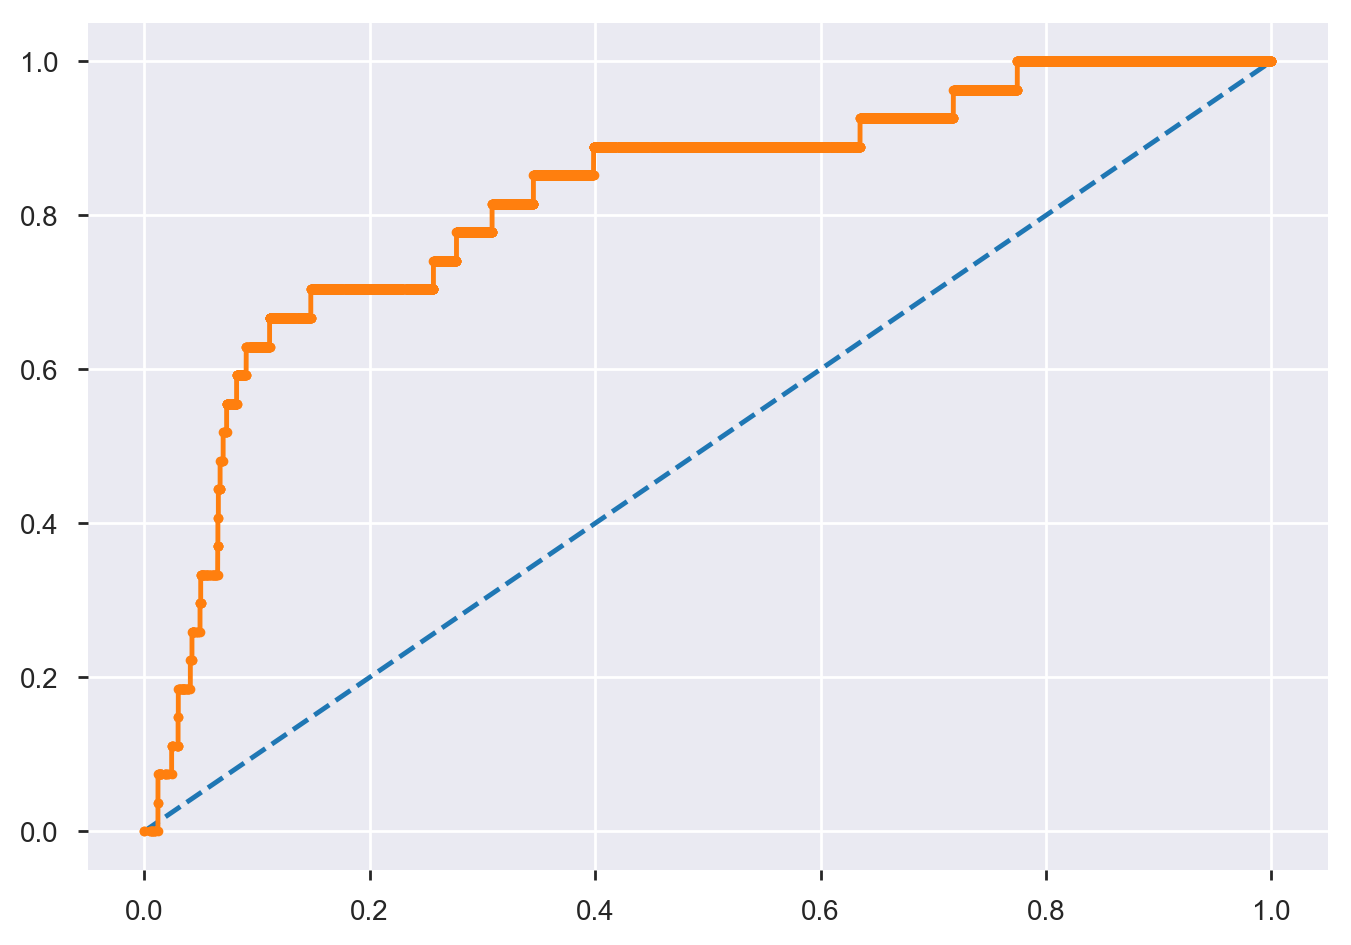

AUC: 0.821
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31097
           1       0.00      0.00      0.00        27

   micro avg       1.00      1.00      1.00     31124
   macro avg       0.50      0.50      0.50     31124
weighted avg       1.00      1.00      1.00     31124


Accuracy 0.9961123248939725
Confusion matrix:
 [[31003    94]
 [   27     0]]


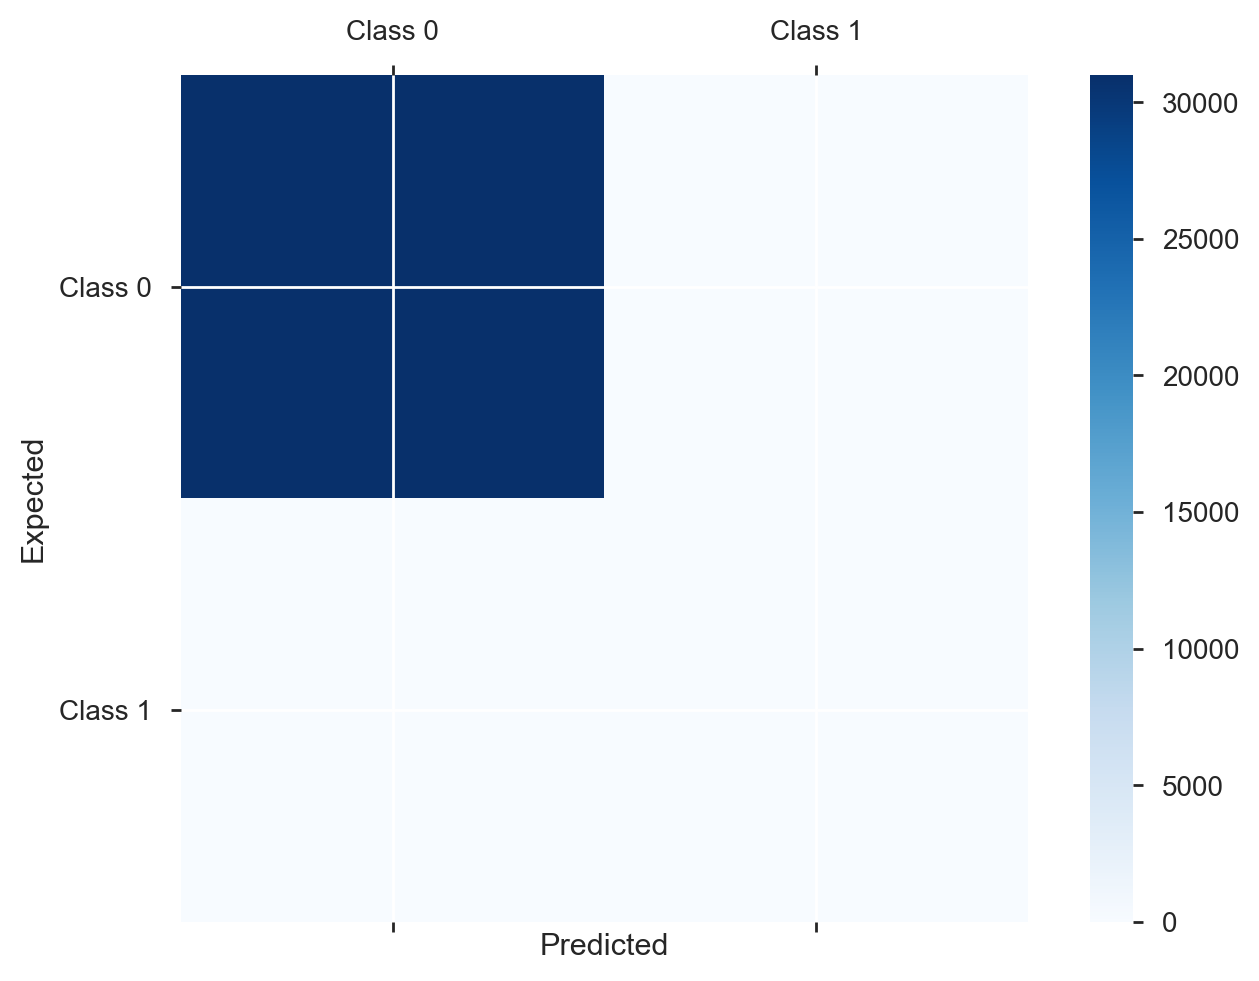

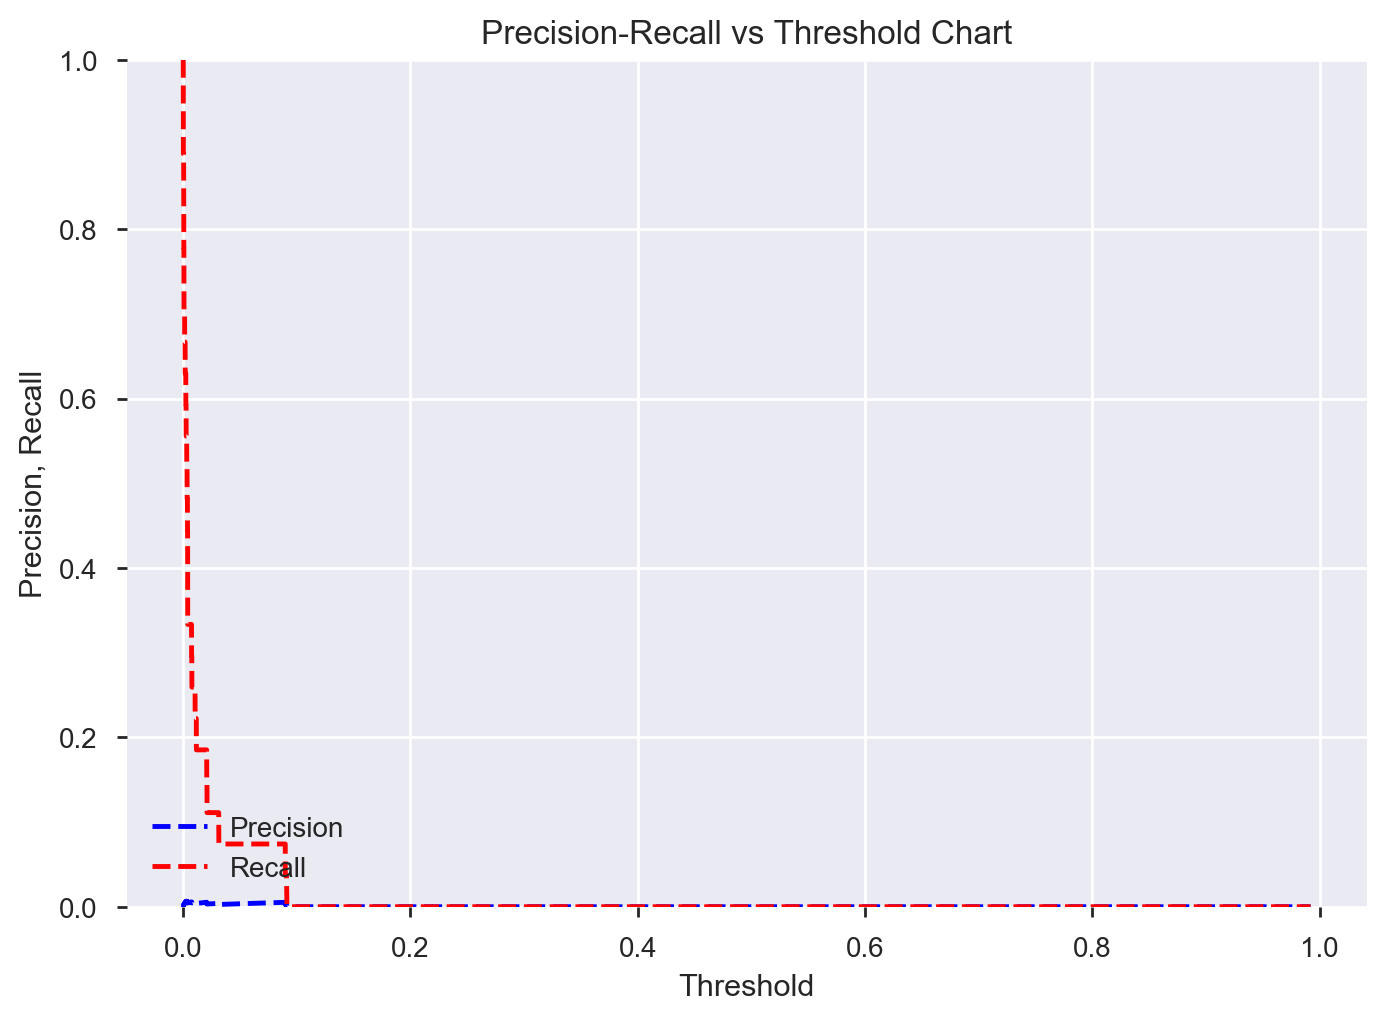

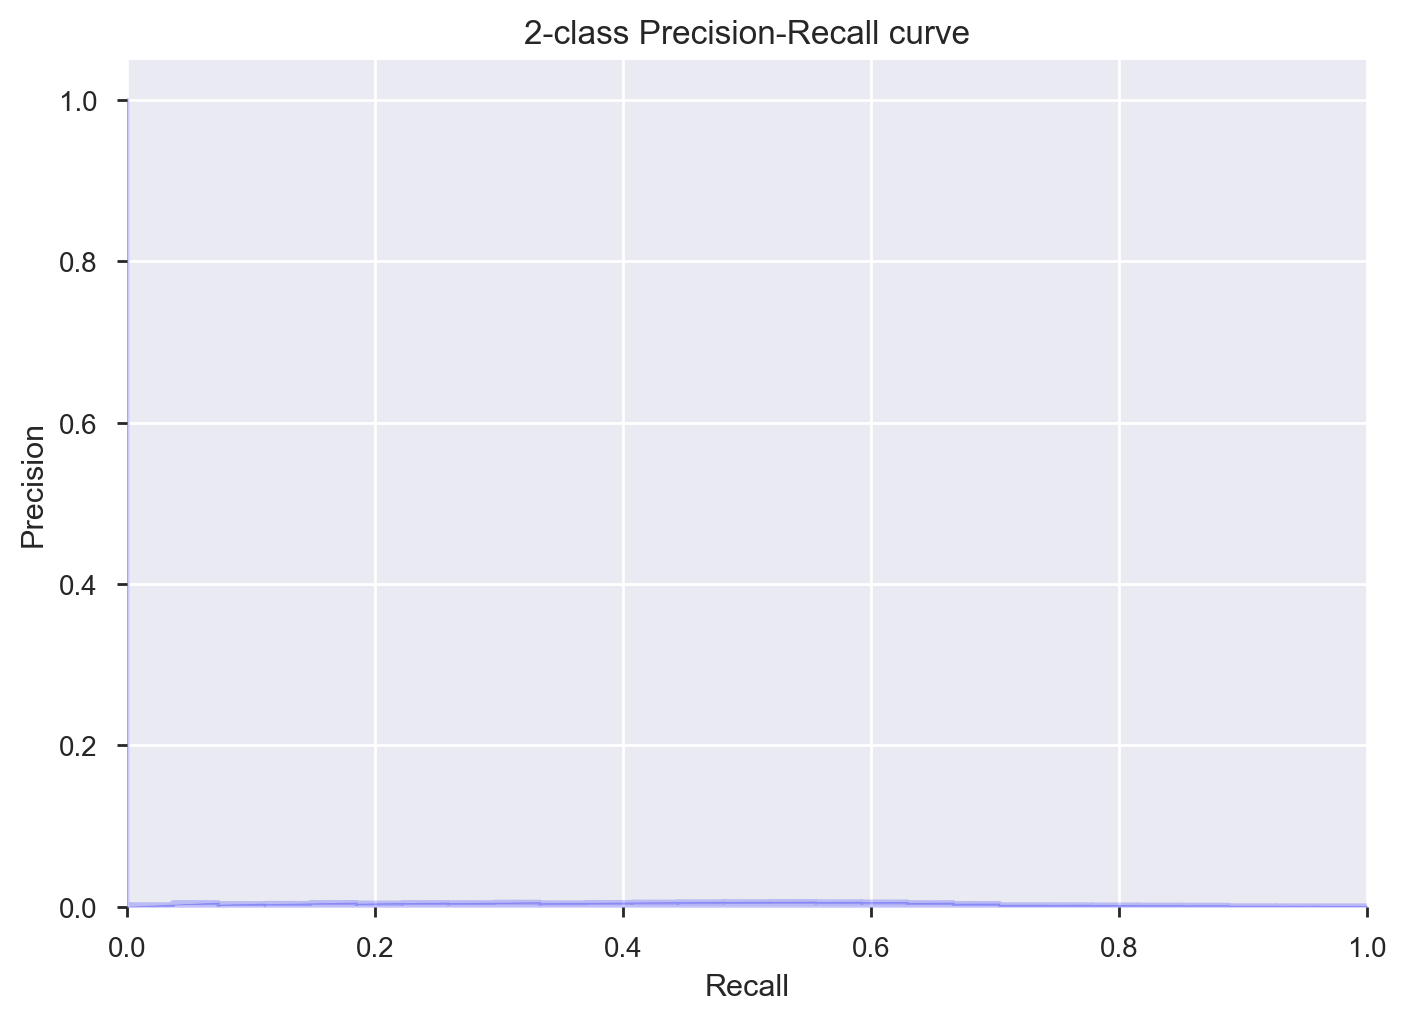

In [242]:
%time
name = 'XGBoost'
features = X_train_sampled_SMOTENC.columns
X = {'train': X_train_sampled_SMOTENC.as_matrix(), 'test':X_test[features].as_matrix()}
y = {'train': y_train_sampled_SMOTENC.as_matrix(), 'test':y_test.as_matrix()}

opt = HyperTuning.baysian_search(name, X['train'], y['train'])
HyperTuning.evaluate_opt(opt, X, y)


## XGBoost with SMOTENC Oversampling (metrics + day of week features)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.3min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


Finished Training
Best model

Pipeline(memory=None,
     steps=[('clsfr', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.46909356296798244, gamma=7.277257431773251,
       learning_rate=0.008567773934012713, max_delta_step=1, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1472, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4727067692369846))])


Best score on the validation: 0.9923786007233075
   mean_test_score  rank_test_score  \
0         0.992379                1   
1         0.983139                1   
2         0.965097                1   
3         0.982736                1   
4         0.990396                1   

                                              params  
0  {'clsfr__colsample_bytree': 0.4690935629679824...  
1  {'clsfr__colsample_bytree': 0.8536495199979559...  
2  {'cl

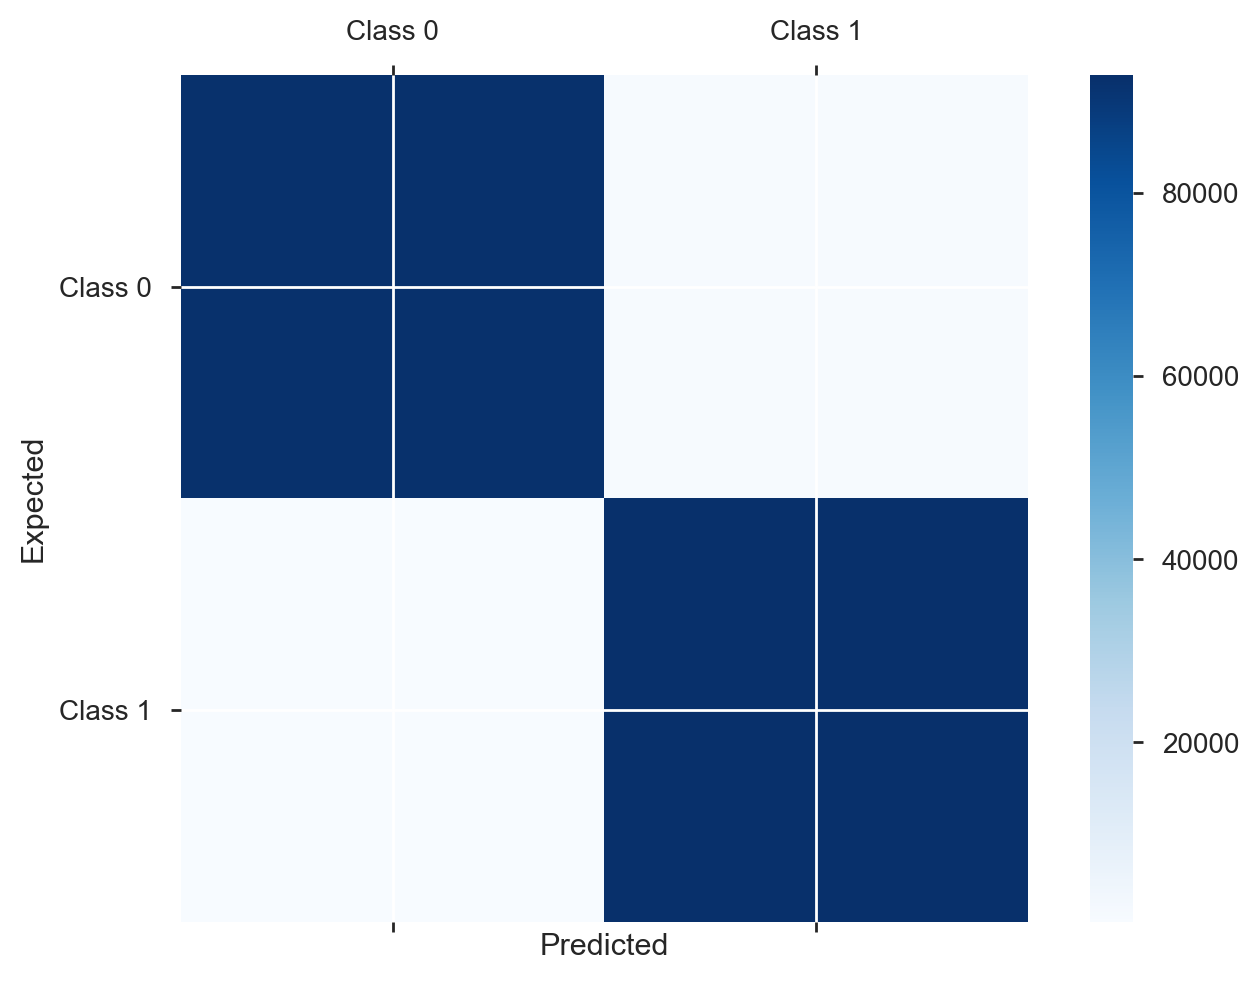

*****************Testing***************************


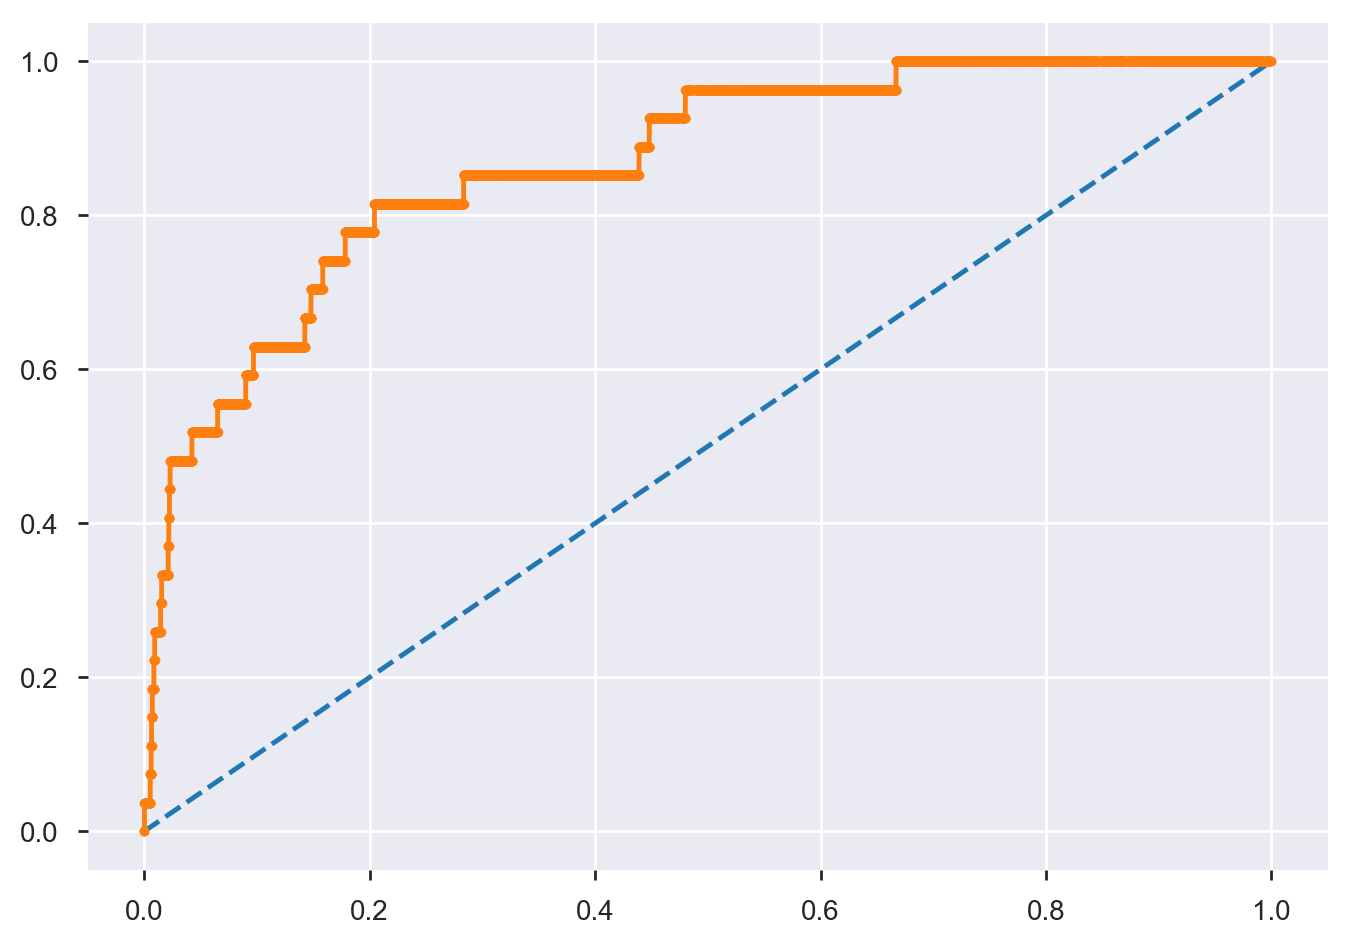

AUC: 0.866
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     31097
           1       0.02      0.26      0.04        27

   micro avg       0.99      0.99      0.99     31124
   macro avg       0.51      0.62      0.52     31124
weighted avg       1.00      0.99      0.99     31124


Accuracy 0.9893972497108341
Confusion matrix:
 [[30787   310]
 [   20     7]]


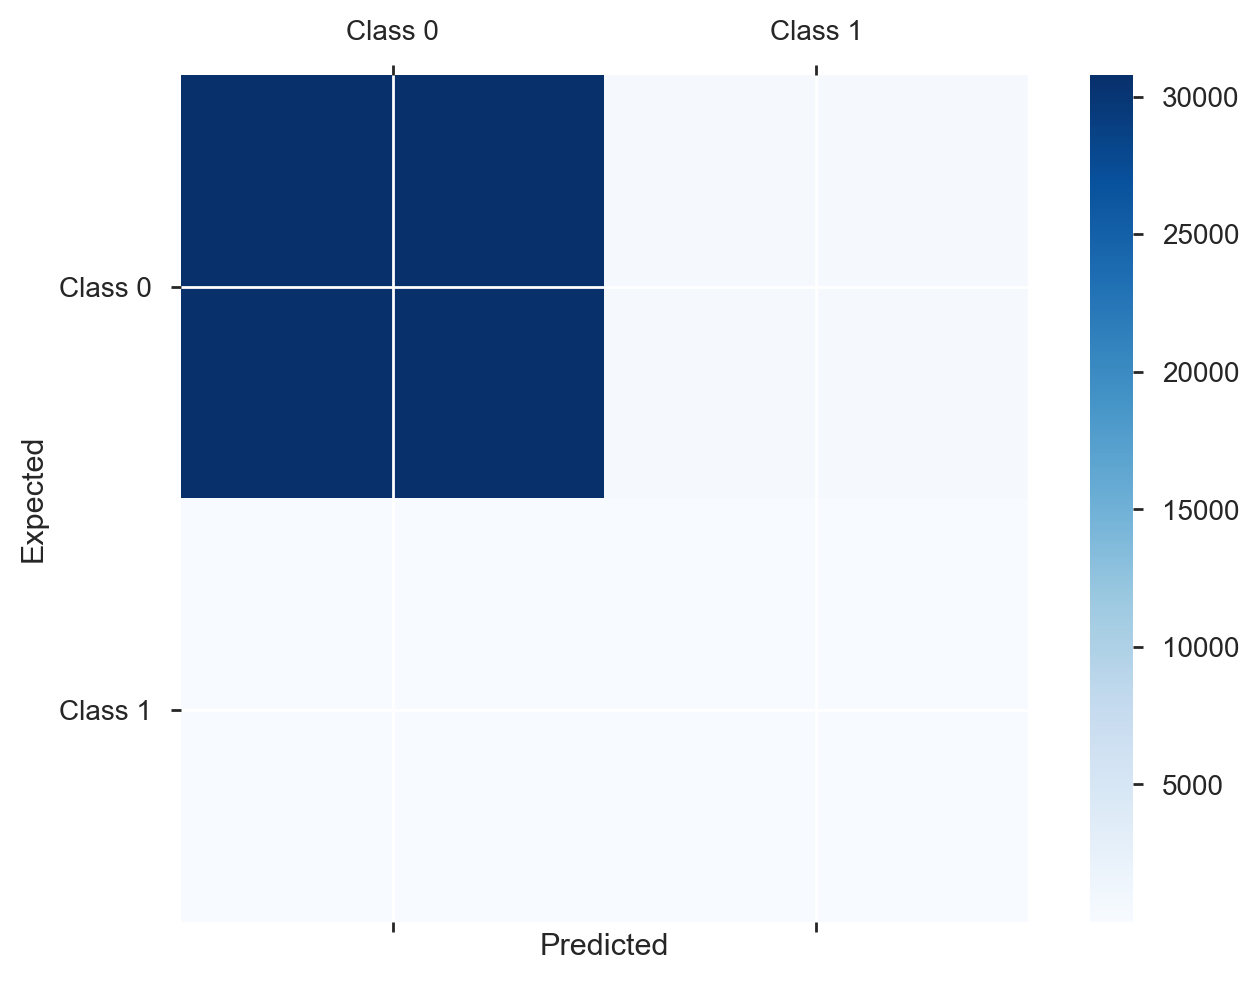

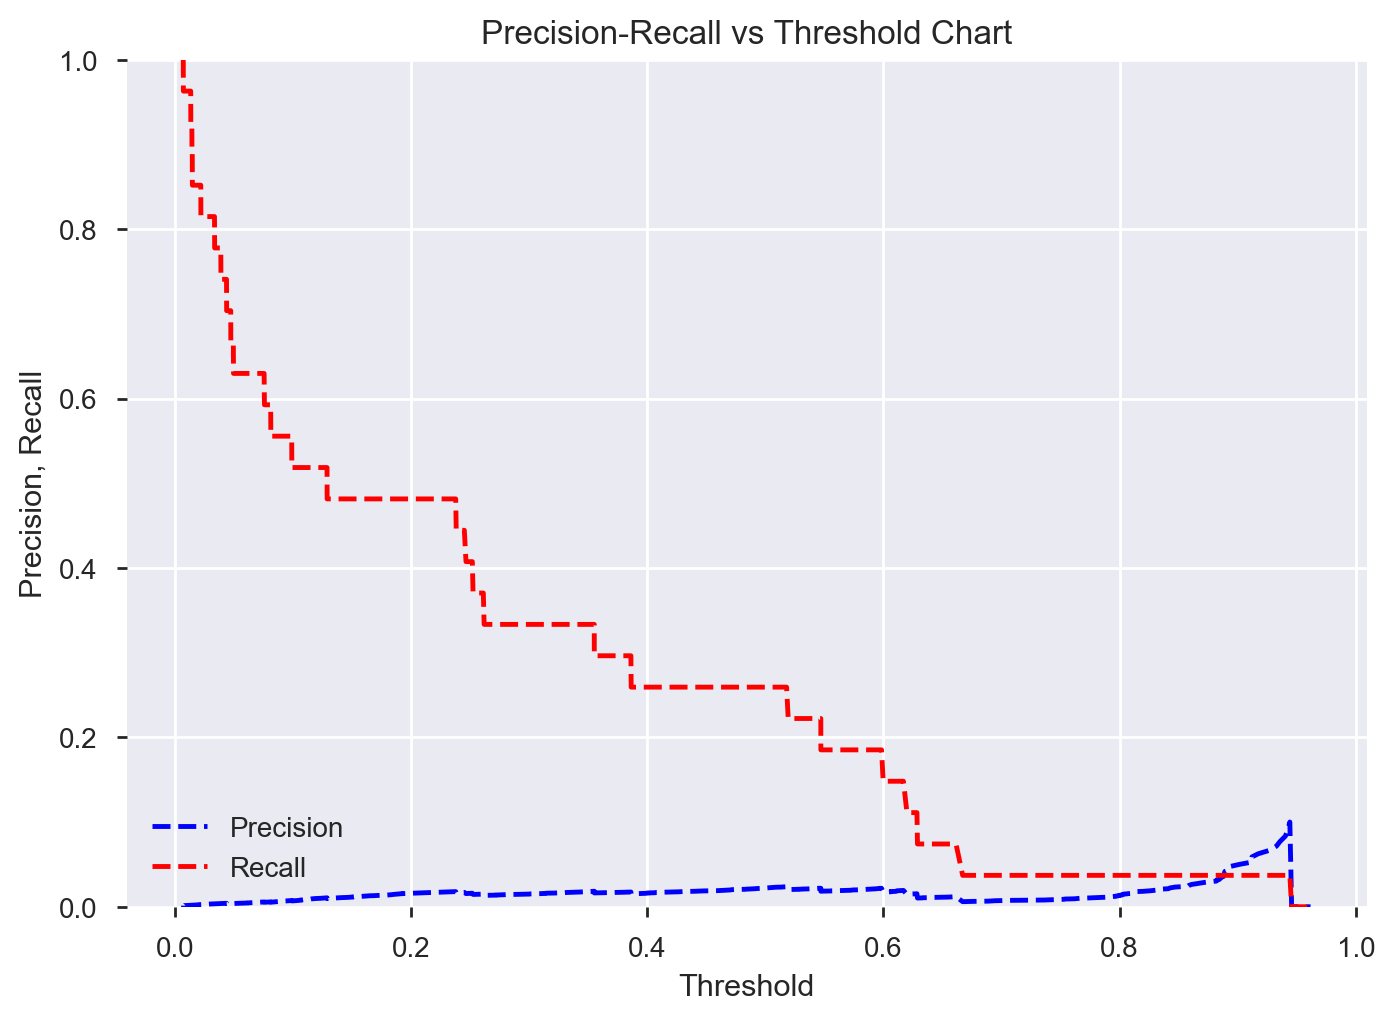

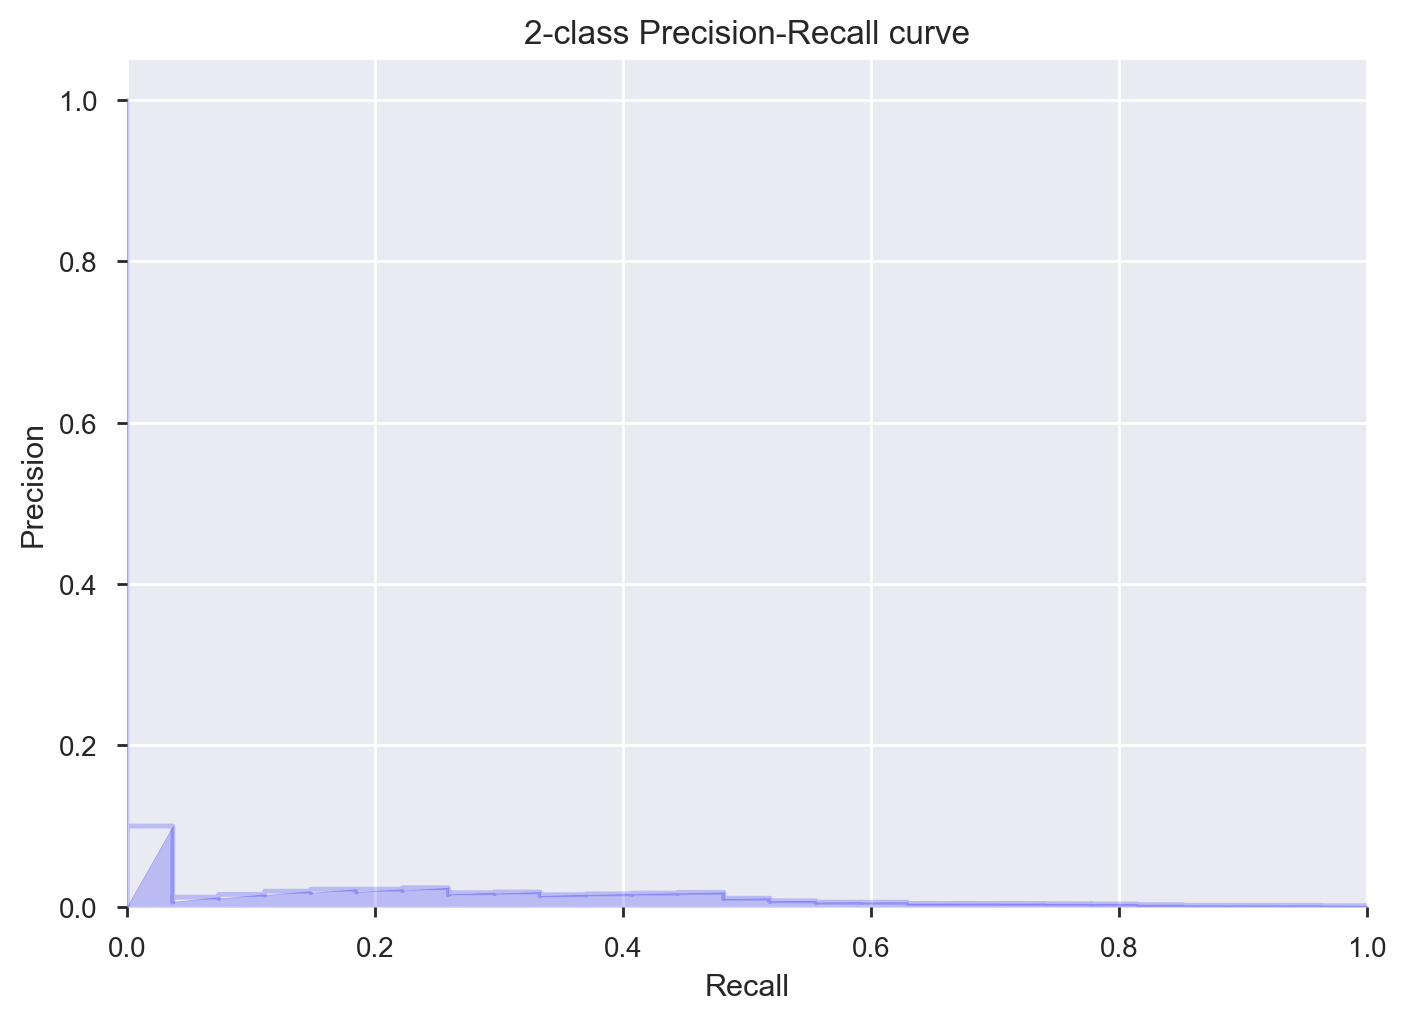

In [90]:
%time
name = 'XGBoost'
features = X_train_sampled_SMOTENC.columns.difference([c for c in X_train_sampled_SMOTENC.columns if 'month' in c])
features = features.difference(['id'])

X = {'train': X_train_sampled_SMOTENC[features].as_matrix(), 'test':X_test[features].as_matrix()}
y = {'train': y_train_sampled_SMOTENC.as_matrix(), 'test':y_test.as_matrix()}

opt = HyperTuning.baysian_search(name, X['train'], y['train'])
HyperTuning.evaluate_opt(opt, X, y)

## SageMaker Implementation
To do: implementing the container for sagemaker, to be done next couple of weeks